In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 36.7 MB/s eta 0:00:00


In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.5 MB/s eta 0:00:00


In [ ]:

# Base libraries
from multiprocessing import Pool

import os
import numpy as np
import mne
import pandas as pd
import random

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
import mne
import matplotlib
from collections import defaultdict
from math import cos, sin, acos, radians, pi
from scipy.interpolate import griddata
from numpy import newaxis
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# Wavelets
import pywt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # Load and combine EEG data

In [ ]:
# Importing the data using multiprocessing

# 10x speed increase for reading 900 csv files


train_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TRAIN'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/Alcohol/SMNI_CMI_TEST'

# wrap your csv importer in a function that can be mapped
def read_csv(filename):
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename)


# get a list of file names
files_train = os.listdir(train_dir)
file_list_train = [os.path.join(train_dir,filename) for filename in files_train if filename.split('.')[1]=='csv']

files_test = os.listdir(test_dir)
file_list_test = [os.path.join(test_dir,filename) for filename in files_test if filename.split('.')[1]=='csv']

# set up your pool
with Pool(processes=12) as pool:

    # pool maps the dataframe


    df_list_train = pool.map(read_csv, file_list_train)
    df_list_test =  pool.map(read_csv, file_list_test)


# reduce the list of dataframes to a single dataframe
combined_df_train = pd.concat(df_list_train, ignore_index=True)
combined_df_test = pd.concat(df_list_test, ignore_index=True)
combined_df = pd.concat([combined_df_train,combined_df_test], ignore_index=True)


EEG_data = combined_df[combined_df['subject identifier'] == 'a']
EEG_data_control = combined_df[combined_df['subject identifier'] == 'c']

EEG_data.head()

Unnamed: 0  trial number sensor position  sample num  sensor value  \
0           5            14             FP1           0        -5.656   
1           6            14             FP1           1        -6.632   
2           7            14             FP1           2        -7.121   
3           8            14             FP1           3        -9.074   
4           9            14             FP1           4       -11.027   

  subject identifier matching condition  channel         name      time  
0                  a             S1 obj        0  co2a0000369  0.000000  
1                  a             S1 obj        0  co2a0000369  0.003906  
2                  a             S1 obj        0  co2a0000369  0.007812  
3                  a             S1 obj        0  co2a0000369  0.011719  
4                  a             S1 obj        0  co2a0000369  0.015625

In [ ]:
del combined_df

# Standardize sensor position names

In [ ]:
# standardizing the sensor position naming convention


EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign e


EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data.loc[EEG_data['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data.loc[EEG_data['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data.loc[EEG_data['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data.loc[EEG_data['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data.loc[EEG_data['sensor position'] == 'CZ', 'sensor position'] = 'Cz'

EEG_data.loc[EEG_data['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data.loc[EEG_data['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data.loc[EEG_data['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data.loc[EEG_data['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data.loc[EEG_data['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data.loc[EEG_data['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

## Control Group


EEG_data_control = EEG_data_control.drop(['Unnamed: 0'], axis=1)
EEG_data_control.loc[EEG_data_control['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch'
## replace some 'sensor position' values
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'CZ', 'sensor position'] = 'Cz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'OZ', 'sensor position'] = 'Oz'
EEG_data_control.head()

trial number sensor position  sample num  sensor value  \
2228224            30             Fp1           0        -4.435   
2228225            30             Fp1           1        -5.900   
2228226            30             Fp1           2        -8.341   
2228227            30             Fp1           3        -8.830   
2228228            30             Fp1           4        -6.388   

        subject identifier matching condition  channel         name      time  
2228224                  c             S1 obj        0  co2c0000337  0.000000  
2228225                  c             S1 obj        0  co2c0000337  0.003906  
2228226                  c             S1 obj        0  co2c0000337  0.007812  
2228227                  c             S1 obj        0  co2c0000337  0.011719  
2228228                  c             S1 obj        0  co2c0000337  0.015625

In [ ]:
EEG_data.shape

(7782400, 9)

# Organize data by experiment condition groups

In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
df = EEG_data

# Specify the column name you want to analyze
column_name = 'name'

# Find unique values in the specified column
unique_values = df[column_name].unique()

# Count the number of unique values in the specified column
num_unique_values = df[column_name].nunique()

# Display the unique values and their count
print(f"Unique values in column '{column_name}':\n{unique_values}")
print(f"Number of unique values: {num_unique_values}")


Unique values in column 'name':
['co2a0000369' 'co2a0000364' 'co2a0000370' 'co2a0000371' 'co2a0000372'
 'co2a0000375' 'co2a0000365' 'co2a0000368']
Number of unique values: 8


In [ ]:
EEG_data_control.shape

(7749632, 9)

In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
df = EEG_data_control

# Specify the column name you want to analyze
column_name = 'name'

# Find unique values in the specified column
unique_values = df[column_name].unique()

# Count the number of unique values in the specified column
num_unique_values = df[column_name].nunique()

# Display the unique values and their count
print(f"Unique values in column '{column_name}':\n{unique_values}")
print(f"Number of unique values: {num_unique_values}")


Unique values in column 'name':
['co2c0000337' 'co2c0000338' 'co2c0000339' 'co2c0000340' 'co2c0000341'
 'co2c0000342' 'co2c0000344' 'co2c0000345']
Number of unique values: 8


In [ ]:
# Organzing according to experiment condition groups

#Alc_Groups
Alc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']
Alc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']
Alc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']

#Control groups
Con_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']
Con_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']
Con_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']


def trial_len_integrity_check(inputDF):

  nameAndTrialNumber = inputDF.groupby(['trial number','name']).size().reset_index().rename(columns={0:'count'})
  nameAndTrialNumber['count'] =np.where(nameAndTrialNumber['count'] == 16384,False,True)

  del inputDF

  if nameAndTrialNumber['count'].any():
    # data integrity problem
    Exception('Data Integrity problem, one of the arrays is not shaped 256x256')


  return nameAndTrialNumber[['trial number','name']]


# Creating dataframes that contain relevant indexing information and checks data integrity
# Trial Number, and subject names

Con_S1Obj_Index = trial_len_integrity_check(Con_S1Obj)
Con_S2Match_Index = trial_len_integrity_check(Con_S2Match)
Con_S2Nomatch_Index = trial_len_integrity_check(Con_S2Nomatch)

Alc_S1Obj_Index = trial_len_integrity_check(Alc_S1Obj)
Alc_S2Match_Index = trial_len_integrity_check(Alc_S2Match)
Alc_S2Nomatch_Index = trial_len_integrity_check(Alc_S2Nomatch)



Alc_S1Obj_Index.head()

trial number         name
0             0  co2a0000364
1             0  co2a0000368
2             0  co2a0000369
3             0  co2a0000370
4             0  co2a0000371

In [ ]:
Con_S2Nomatch_Index

trial number         name
0               5  co2c0000338
1               5  co2c0000339
2               5  co2c0000340
3               5  co2c0000341
4               5  co2c0000342
..            ...          ...
141           103  co2c0000340
142           111  co2c0000337
143           111  co2c0000340
144           115  co2c0000337
145           115  co2c0000340

[146 rows x 2 columns]

In [ ]:
Alc_S2Nomatch_Index

trial number         name
0               5  co2a0000365
1               5  co2a0000368
2               5  co2a0000370
3               5  co2a0000371
4               5  co2a0000372
..            ...          ...
150            95  co2a0000364
151            95  co2a0000365
152           103  co2a0000364
153           103  co2a0000365
154           111  co2a0000364

[155 rows x 2 columns]

In [ ]:
# Organzing according to experiment condition groups

#Alc_Groups
Alc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']
Alc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']
Alc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']

#Control groups
Con_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']
Con_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']
Con_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']


def trial_len_integrity_check(inputDF):

  nameAndTrialNumber = inputDF.groupby(['trial number','name']).size().reset_index().rename(columns={0:'count'})
  nameAndTrialNumber['count'] =np.where(nameAndTrialNumber['count'] == 16384,False,True)

  del inputDF

  if nameAndTrialNumber['count'].any():
    # data integrity problem
    Exception('Data Integrity problem, one of the arrays is not shaped 256x256')


  return nameAndTrialNumber[['trial number','name']]


# Creating dataframes that contain relevant indexing information and checks data integrity
# Trial Number, and subject names

Con_S1Obj_Index = trial_len_integrity_check(Con_S1Obj)
Con_S2Match_Index = trial_len_integrity_check(Con_S2Match)
Con_S2Nomatch_Index = trial_len_integrity_check(Con_S2Nomatch)

Alc_S1Obj_Index = trial_len_integrity_check(Alc_S1Obj)
Alc_S2Match_Index = trial_len_integrity_check(Alc_S2Match)
Alc_S2Nomatch_Index = trial_len_integrity_check(Alc_S2Nomatch)

All_Alcs = pd.concat([Alc_S1Obj_Index,Alc_S2Match_Index,Alc_S2Nomatch_Index])
All_Cons = pd.concat([Con_S1Obj_Index,Con_S2Match_Index,Con_S2Nomatch_Index])

All_Alcs.reset_index(drop=True,inplace=True)
All_Cons.reset_index(drop=True,inplace=True)


In [ ]:
All_Alcs

trial number         name
0               0  co2a0000364
1               0  co2a0000368
2               0  co2a0000369
3               0  co2a0000370
4               0  co2a0000371
..            ...          ...
463            95  co2a0000364
464            95  co2a0000365
465           103  co2a0000364
466           103  co2a0000365
467           111  co2a0000364

[468 rows x 2 columns]

In [ ]:
All_Cons

trial number         name
0               0  co2c0000337
1               0  co2c0000338
2               0  co2c0000339
3               0  co2c0000340
4               0  co2c0000341
..            ...          ...
451           103  co2c0000340
452           111  co2c0000337
453           111  co2c0000340
454           115  co2c0000337
455           115  co2c0000340

[456 rows x 2 columns]

In [ ]:
# visualizing the time series channels
TrueCrimeSubjectZero = EEG_data[((EEG_data.name == 'co2a0000364') & (EEG_data['trial number'] == 0))]
print('Number of data points on example subject Zero, Trial Zero')
print(TrueCrimeSubjectZero.shape)
print('Number of Channels')
print(TrueCrimeSubjectZero.shape[0] / 256)
print('Sampling Rate')
print(TrueCrimeSubjectZero.shape[0] / 64)

Number of data points on example subject Zero, Trial Zero
(16384, 9)
Number of Channels
64.0
Sampling Rate
256.0


In [ ]:
TrueCrimeSubjectZero

trial number sensor position  sample num  sensor value  \
49152             0             Fp1           0        -8.921   
49153             0             Fp1           1        -8.433   
49154             0             Fp1           2        -2.574   
49155             0             Fp1           3         5.239   
49156             0             Fp1           4        11.587   
...             ...             ...         ...           ...   
65531             0               Y         251         6.571   
65532             0               Y         252        12.431   
65533             0               Y         253        15.849   
65534             0               Y         254        16.337   
65535             0               Y         255        14.872   

      subject identifier matching condition  channel         name      time  
49152                  a             S1 obj        0  co2a0000364  0.000000  
49153                  a             S1 obj        0  co2a0000364  0.003906  
49154                  a             S1 obj        0  co2a0000364  0.007812  
49155                  a             S1 obj        0  co2a0000364  0.011719  
49156                  a             S1 obj        0  co2a0000364  0.015625  
...                  ...                ...      ...          ...       ...  
65531                  a             S1 obj       63  co2a0000364  0.980469  
65532                  a             S1 obj       63  co2a0000364  0.984375  
65533                  a             S1 obj       63  co2a0000364  0.988281  
65534                  a             S1 obj       63  co2a0000364  0.992188  
65535                  a             S1 obj       63  co2a0000364  0.996094  

[16384 rows x 9 columns]

In [ ]:
# Aggregate duplicate entries by taking the mean of the 'sensor value'
#It means combining duplicate records and calculating the average of the 'sensor value' for those records.
EEG_data_agg = EEG_data.groupby(['time', 'sensor position']).agg({'sensor value': 'mean'}).reset_index()
EEG_data_agg

time sensor position  sensor value
0      0.000000             AF3      0.312027
1      0.000000             AF4      0.150827
2      0.000000             AF7      0.293642
3      0.000000             AF8     -0.108623
4      0.000000             AFz      0.237417
...         ...             ...           ...
16379  0.996094             TP7     -3.136034
16380  0.996094             TP8     -3.252223
16381  0.996094               X      5.428863
16382  0.996094               Y     -2.497105
16383  0.996094              nd     -0.063968

[16384 rows x 3 columns]

# Visualize time series data

In [ ]:
# Pivot the data after handling duplicates
#After managing duplicates, reorganize the data so that each unique value becomes a column, summarizing the data in a more organized format.
EEG_data_pivoted = EEG_data_agg.pivot(index='time', columns='sensor position', values='sensor value')
EEG_data_pivoted

sensor position       AF3       AF4       AF7       AF8       AFz        C1  \
time                                                                          
0.000000         0.312027  0.150827  0.293642 -0.108623  0.237417  0.507324   
0.003906         0.265792  0.152901  0.258676 -0.190884  0.202461  0.096116   
0.007812         0.246248  0.177560  0.253505 -0.151827  0.183981  0.170160   
0.011719         0.267832  0.226899  0.340876  0.042459  0.222013  0.043709   
0.015625         0.321303  0.291632  0.508469  0.212067  0.268248  0.313017   
...                   ...       ...       ...       ...       ...       ...   
0.980469        -0.086811  0.260834  1.433611  1.522716  0.323762 -0.714924   
0.984375        -0.073455  0.286499  1.361648  1.649143  0.369008 -0.760164   
0.988281         0.058158  0.382122  1.351352  1.734493  0.445082 -0.913312   
0.992188         0.217488  0.525006  1.456232  1.818771  0.592065 -0.801276   
0.996094         0.320265  0.648362  1.701935  1.824958  0.696916 -0.819775   

sensor position        C2        C3        C4        C5  ...       PO8  \
time                                                     ...             
0.000000         0.277484  0.327225 -0.019539  0.326091  ...  0.573855   
0.003906        -0.088440  0.306655 -0.111027  0.292175  ...  0.335377   
0.007812        -0.076124  0.398168 -0.137783  0.260284  ...  0.342568   
0.011719        -0.007248  0.234722  0.119227  0.274682  ... -0.089131   
0.015625         0.129488  0.367337 -0.046286  0.282905  ...  0.289097   
...                   ...       ...       ...       ...  ...       ...   
0.980469        -0.653840 -1.113949 -1.079368 -2.043381  ... -4.215402   
0.984375        -0.670303 -1.089282 -1.054699 -2.000206  ... -4.298676   
0.988281        -0.578783 -1.496387 -0.891288 -1.928263  ... -4.128015   
0.992188        -0.488331 -1.102661 -0.525324 -1.903560  ... -4.408682   
0.996094        -0.667183 -1.202362 -1.068076 -1.913844  ... -4.514539   

sensor position       POz        Pz        T7        T8       TP7       TP8  \
time                                                                          
0.000000         0.124958  0.048505  0.110771 -0.088082  0.347705  0.215072   
0.003906         0.162998  0.063935  0.104589 -0.030503  0.230528 -0.020314   
0.007812         0.171215  0.091707  0.224874  0.089800  0.234615 -0.177604   
0.011719         0.119840  0.090638  0.367745  0.192547  0.259301 -0.212552   
0.015625         0.037594  0.074202  0.393455  0.105185  0.270602 -0.212526   
...                   ...       ...       ...       ...       ...       ...   
0.980469        -2.388387 -1.173745 -2.916566 -2.616840 -3.242943 -3.351966   
0.984375        -2.381200 -1.207667 -2.867225 -2.261185 -3.250152 -3.169996   
0.988281        -2.413063 -1.232343 -2.740821 -1.922958 -3.212101 -3.070267   
0.992188        -2.497377 -1.306339 -2.634920 -1.861295 -3.163813 -3.111398   
0.996094        -2.614549 -1.400869 -2.580461 -2.051469 -3.136034 -3.252223   

sensor position         X         Y        nd  
time                                           
0.000000         0.256200  0.733764  0.178627  
0.003906         0.160573  0.824206  0.253676  
0.007812         0.111263  0.862261  0.284505  
0.011719         0.147227  0.837621  0.257796  
0.015625         0.201716  0.745074  0.220766  
...                   ...       ...       ...  
0.980469         4.924160 -2.978185  0.013118  
0.984375         5.103034 -2.773636  0.058354  
0.988281         5.288053 -2.588581  0.057312  
0.992188         5.408333 -2.490954  0.009006  
0.996094         5.428863 -2.497105 -0.063968  

[256 rows x 64 columns]

In [ ]:
EEG_data_pivoted.drop(columns=['X','Y','nd'],inplace=True)
EEG_data_pivoted

sensor position       AF3       AF4       AF7       AF8       AFz        C1  \
time                                                                          
0.000000         0.312027  0.150827  0.293642 -0.108623  0.237417  0.507324   
0.003906         0.265792  0.152901  0.258676 -0.190884  0.202461  0.096116   
0.007812         0.246248  0.177560  0.253505 -0.151827  0.183981  0.170160   
0.011719         0.267832  0.226899  0.340876  0.042459  0.222013  0.043709   
0.015625         0.321303  0.291632  0.508469  0.212067  0.268248  0.313017   
...                   ...       ...       ...       ...       ...       ...   
0.980469        -0.086811  0.260834  1.433611  1.522716  0.323762 -0.714924   
0.984375        -0.073455  0.286499  1.361648  1.649143  0.369008 -0.760164   
0.988281         0.058158  0.382122  1.351352  1.734493  0.445082 -0.913312   
0.992188         0.217488  0.525006  1.456232  1.818771  0.592065 -0.801276   
0.996094         0.320265  0.648362  1.701935  1.824958  0.696916 -0.819775   

sensor position        C2        C3        C4        C5  ...       PO3  \
time                                                     ...             
0.000000         0.277484  0.327225 -0.019539  0.326091  ...  0.169909   
0.003906        -0.088440  0.306655 -0.111027  0.292175  ...  0.199680   
0.007812        -0.076124  0.398168 -0.137783  0.260284  ...  0.227438   
0.011719        -0.007248  0.234722  0.119227  0.274682  ...  0.232596   
0.015625         0.129488  0.367337 -0.046286  0.282905  ...  0.183261   
...                   ...       ...       ...       ...  ...       ...   
0.980469        -0.653840 -1.113949 -1.079368 -2.043381  ... -2.806088   
0.984375        -0.670303 -1.089282 -1.054699 -2.000206  ... -2.764928   
0.988281        -0.578783 -1.496387 -0.891288 -1.928263  ... -2.789611   
0.992188        -0.488331 -1.102661 -0.525324 -1.903560  ... -2.873907   
0.996094        -0.667183 -1.202362 -1.068076 -1.913844  ... -2.958194   

sensor position       PO4       PO7       PO8       POz        Pz        T7  \
time                                                                          
0.000000         0.034352  0.394147  0.573855  0.124958  0.048505  0.110771   
0.003906         0.070301  0.432158  0.335377  0.162998  0.063935  0.104589   
0.007812         0.077476  0.530846  0.342568  0.171215  0.091707  0.224874   
0.011719        -0.020160  0.433196 -0.089131  0.119840  0.090638  0.367745   
0.015625        -0.137335  0.433208  0.289097  0.037594  0.074202  0.393455   
...                   ...       ...       ...       ...       ...       ...   
0.980469        -4.017886 -3.909933 -4.215402 -2.388387 -1.173745 -2.916566   
0.984375        -3.970596 -3.657057 -4.298676 -2.381200 -1.207667 -2.867225   
0.988281        -3.970621 -3.614920 -4.128015 -2.413063 -1.232343 -2.740821   
0.992188        -4.069288 -3.929469 -4.408682 -2.497377 -1.306339 -2.634920   
0.996094        -4.241979 -4.090844 -4.514539 -2.614549 -1.400869 -2.580461   

sensor position        T8       TP7       TP8  
time                                           
0.000000        -0.088082  0.347705  0.215072  
0.003906        -0.030503  0.230528 -0.020314  
0.007812         0.089800  0.234615 -0.177604  
0.011719         0.192547  0.259301 -0.212552  
0.015625         0.105185  0.270602 -0.212526  
...                   ...       ...       ...  
0.980469        -2.616840 -3.242943 -3.351966  
0.984375        -2.261185 -3.250152 -3.169996  
0.988281        -1.922958 -3.212101 -3.070267  
0.992188        -1.861295 -3.163813 -3.111398  
0.996094        -2.051469 -3.136034 -3.252223  

[256 rows x 61 columns]

In [ ]:
# EEG_data_pivoted.to_csv('EEG_data_pivoted.csv')


In [ ]:
pip install numpy pandas pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.4 MB/s eta 0:00:00


In [ ]:
# import numpy as np
# import pandas as pd
# import pyedflib
# import os

# # Load CSV data
# csv_file = 'EEG_data_pivoted.csv'  # Replace with your CSV file path
# data = pd.read_csv(csv_file)

# # Assuming each column in your CSV corresponds to a different EEG channel
# channels = list(data.columns)
# n_channels = len(channels)
# n_samples = len(data)

# # Create a BDF/EDF file
# edf_file = 'EEG_data.edf'  # Change to 'output_file.bdf' if you want BDF format
# f = pyedflib.EdfWriter(edf_file, n_channels=n_channels, file_type=pyedflib.FILETYPE_EDFPLUS)

# # Set channel info
# channel_info = []
# for channel in channels:
#     ch_dict = {
#         'label': channel,
#         'dimension': 'uV',
#         'sample_rate': 256,  # Set according to your data
#         'physical_min': np.min(data[channel]),
#         'physical_max': np.max(data[channel]),
#         'digital_min': -32768,
#         'digital_max': 32767,
#         'transducer': '',
#         'prefilter': ''
#     }
#     channel_info.append(ch_dict)

# f.setSignalHeaders(channel_info)

# # Write data to the EDF/BDF file
# for channel in channels:
#     f.writePhysicalSamples(data[channel].values)

# # Close the file
# f.close()

# print(f"Data has been successfully saved to {edf_file}")

In [ ]:

# Aggregate duplicate entries by taking the mean of the 'sensor value'
EEG_data_agg = EEG_data.groupby(['time', 'sensor position']).agg({'sensor value': 'mean'}).reset_index()

# Pivot the data after handling duplicates
EEG_data_pivoted = EEG_data_agg.pivot(index='time', columns='sensor position', values='sensor value')
# Drop duplicate entries, keeping the first occurrence
EEG_data_dedup = EEG_data.drop_duplicates(subset=['time', 'sensor position'])

# Pivot the data after handling duplicates
EEG_data_pivoted = EEG_data_dedup.pivot(index='time', columns='sensor position', values='sensor value')
# Identify duplicates
duplicates = EEG_data[EEG_data.duplicated(subset=['time', 'sensor position'], keep=False)]

print(duplicates)



          trial number sensor position  sample num  sensor value  \
0                   14             Fp1           0        -5.656   
1                   14             Fp1           1        -6.632   
2                   14             Fp1           2        -7.121   
3                   14             Fp1           3        -9.074   
4                   14             Fp1           4       -11.027   
...                ...             ...         ...           ...   
15532027            63               Y         251       -23.753   
15532028            63               Y         252       -20.335   
15532029            63               Y         253       -18.870   
15532030            63               Y         254       -19.358   
15532031            63               Y         255       -19.847   

         subject identifier matching condition  channel         name      time  
0                         a             S1 obj        0  co2a0000369  0.000000  
1                    

In [ ]:
duplicates

trial number sensor position  sample num  sensor value  \
0                   14             Fp1           0        -5.656   
1                   14             Fp1           1        -6.632   
2                   14             Fp1           2        -7.121   
3                   14             Fp1           3        -9.074   
4                   14             Fp1           4       -11.027   
...                ...             ...         ...           ...   
15532027            63               Y         251       -23.753   
15532028            63               Y         252       -20.335   
15532029            63               Y         253       -18.870   
15532030            63               Y         254       -19.358   
15532031            63               Y         255       -19.847   

         subject identifier matching condition  channel         name      time  
0                         a             S1 obj        0  co2a0000369  0.000000  
1                         a             S1 obj        0  co2a0000369  0.003906  
2                         a             S1 obj        0  co2a0000369  0.007812  
3                         a             S1 obj        0  co2a0000369  0.011719  
4                         a             S1 obj        0  co2a0000369  0.015625  
...                     ...                ...      ...          ...       ...  
15532027                  a         S2 nomatch       63  co2a0000368  0.980469  
15532028                  a         S2 nomatch       63  co2a0000368  0.984375  
15532029                  a         S2 nomatch       63  co2a0000368  0.988281  
15532030                  a         S2 nomatch       63  co2a0000368  0.992188  
15532031                  a         S2 nomatch       63  co2a0000368  0.996094  

[7782400 rows x 9 columns]

In [ ]:
EEG_data_pivoted

sensor position    AF3    AF4     AF7    AF8    AFz     C1     C2     C3  \
time                                                                       
0.000000        -4.069 -3.682  -6.154 -3.438 -3.977 -0.539  0.702 -0.610   
0.003906        -5.046 -5.636  -7.131 -5.880 -5.442 -1.027  0.214 -2.075   
0.007812        -6.022 -6.612  -8.596 -7.345 -6.419 -1.516  0.214 -3.540   
0.011719        -6.999 -7.589 -10.549 -8.321 -7.395 -2.004 -0.275 -4.517   
0.015625        -7.975 -8.077 -12.502 -8.809 -7.884 -2.492 -0.763 -5.981   
...                ...    ...     ...    ...    ...    ...    ...    ...   
0.980469        -0.163  1.689   0.682  0.956 -0.071 -0.051 -1.251 -0.610   
0.984375         0.814  2.177   1.170  1.444  0.905  0.926 -1.251  0.854   
0.988281         1.302  2.665   1.658  0.956  1.394  1.902 -1.740  1.831   
0.992188         1.790  2.177   2.635 -0.020  1.394  1.902 -1.740  2.319   
0.996094         1.302  0.712   3.123 -2.462  0.417  1.902 -2.716  2.319   

sensor position     C4     C5  ...    PO8    POz     Pz      T7      T8  \
time                           ...                                        
0.000000         0.732 -0.051  ...  2.726  6.144  2.391  -0.559  -2.767   
0.003906        -0.732 -2.492  ...  1.750  4.679  3.367  -3.001  -5.697   
0.007812        -1.709 -4.445  ... -0.203  2.726  3.367  -5.442  -8.138   
0.011719        -2.686 -6.399  ... -2.645  0.773  2.879  -7.884 -10.579   
0.015625        -4.150 -8.352  ... -6.063 -1.668  1.902 -10.325 -13.509   
...                ...    ...  ...    ...    ...    ...     ...     ...   
0.980469        -3.174 -1.027  ... -7.528 -0.203  5.809  -4.954  -7.650   
0.984375        -3.174  0.437  ... -6.551  0.285  6.297  -3.489  -8.138   
0.988281        -3.662  1.902  ... -5.575  0.285  6.297  -2.024  -8.626   
0.992188        -3.662  2.391  ... -6.063 -0.203  6.297  -1.048  -9.115   
0.996094        -4.150  2.391  ... -6.063  0.773  6.297   0.417 -10.091   

sensor position    TP7     TP8       X       Y     nd  
time                                                   
0.000000         2.035  -0.092  -9.979  -5.259  7.090  
0.003906        -1.383  -3.021 -10.956  -7.701  2.696  
0.007812        -3.825  -5.951 -12.421 -10.142 -1.699  
0.011719        -6.755  -9.369 -14.374 -12.095 -4.628  
0.015625        -9.196 -12.787 -16.815 -14.537 -7.070  
...                ...     ...     ...     ...    ...  
0.980469        -6.266  -9.369  -6.561  -1.353 -4.628  
0.984375        -3.825  -9.369  -6.561   0.600 -3.652  
0.988281        -1.383  -9.369  -6.073   1.577 -1.699  
0.992188         0.081  -9.369  -5.585   2.065  0.743  
0.996094         0.570  -9.369  -6.073   2.553  2.696  

[256 rows x 64 columns]

In [ ]:
EEG_data_pivoted.drop(columns=['X','Y','nd'],inplace=True)


In [ ]:
EEG_data_pivoted

sensor position    AF3    AF4     AF7    AF8    AFz     C1     C2     C3  \
time                                                                       
0.000000        -4.069 -3.682  -6.154 -3.438 -3.977 -0.539  0.702 -0.610   
0.003906        -5.046 -5.636  -7.131 -5.880 -5.442 -1.027  0.214 -2.075   
0.007812        -6.022 -6.612  -8.596 -7.345 -6.419 -1.516  0.214 -3.540   
0.011719        -6.999 -7.589 -10.549 -8.321 -7.395 -2.004 -0.275 -4.517   
0.015625        -7.975 -8.077 -12.502 -8.809 -7.884 -2.492 -0.763 -5.981   
...                ...    ...     ...    ...    ...    ...    ...    ...   
0.980469        -0.163  1.689   0.682  0.956 -0.071 -0.051 -1.251 -0.610   
0.984375         0.814  2.177   1.170  1.444  0.905  0.926 -1.251  0.854   
0.988281         1.302  2.665   1.658  0.956  1.394  1.902 -1.740  1.831   
0.992188         1.790  2.177   2.635 -0.020  1.394  1.902 -1.740  2.319   
0.996094         1.302  0.712   3.123 -2.462  0.417  1.902 -2.716  2.319   

sensor position     C4     C5  ...    PO3    PO4    PO7    PO8    POz     Pz  \
time                           ...                                             
0.000000         0.732 -0.051  ...  8.423  4.161  9.410  2.726  6.144  2.391   
0.003906        -0.732 -2.492  ...  5.493  3.672  3.550  1.750  4.679  3.367   
0.007812        -1.709 -4.445  ...  2.075  3.184 -0.844 -0.203  2.726  3.367   
0.011719        -2.686 -6.399  ... -0.854  1.231 -4.262 -2.645  0.773  2.879   
0.015625        -4.150 -8.352  ... -3.296 -1.211 -6.704 -6.063 -1.668  1.902   
...                ...    ...  ...    ...    ...    ...    ...    ...    ...   
0.980469        -3.174 -1.027  ...  0.610 -1.211 -4.751 -7.528 -0.203  5.809   
0.984375        -3.174  0.437  ...  2.075 -2.187 -1.821 -6.551  0.285  6.297   
0.988281        -3.662  1.902  ...  2.563 -3.652 -0.844 -5.575  0.285  6.297   
0.992188        -3.662  2.391  ...  3.052 -4.140  0.132 -6.063 -0.203  6.297   
0.996094        -4.150  2.391  ...  3.540 -3.652  1.597 -6.063  0.773  6.297   

sensor position      T7      T8    TP7     TP8  
time                                            
0.000000         -0.559  -2.767  2.035  -0.092  
0.003906         -3.001  -5.697 -1.383  -3.021  
0.007812         -5.442  -8.138 -3.825  -5.951  
0.011719         -7.884 -10.579 -6.755  -9.369  
0.015625        -10.325 -13.509 -9.196 -12.787  
...                 ...     ...    ...     ...  
0.980469         -4.954  -7.650 -6.266  -9.369  
0.984375         -3.489  -8.138 -3.825  -9.369  
0.988281         -2.024  -8.626 -1.383  -9.369  
0.992188         -1.048  -9.115  0.081  -9.369  
0.996094          0.417 -10.091  0.570  -9.369  

[256 rows x 61 columns]

In [ ]:
# Calculate the correlation matrix
distance_matrix = np.corrcoef(EEG_data_pivoted.T)  # Transpose to correlate channels
distance_matrix

array([[1.        , 0.98903363, 0.95990843, ..., 0.82195507, 0.78144148,
        0.79323892],
       [0.98903363, 1.        , 0.94266551, ..., 0.85148307, 0.77633443,
        0.81003256],
       [0.95990843, 0.94266551, 1.        , ..., 0.84132373, 0.80920495,
        0.81003479],
       ...,
       [0.82195507, 0.85148307, 0.84132373, ..., 1.        , 0.84337081,
        0.9524123 ],
       [0.78144148, 0.77633443, 0.80920495, ..., 0.84337081, 1.        ,
        0.89297771],
       [0.79323892, 0.81003256, 0.81003479, ..., 0.9524123 , 0.89297771,
        1.        ]])

# Frequency analysis with FFT

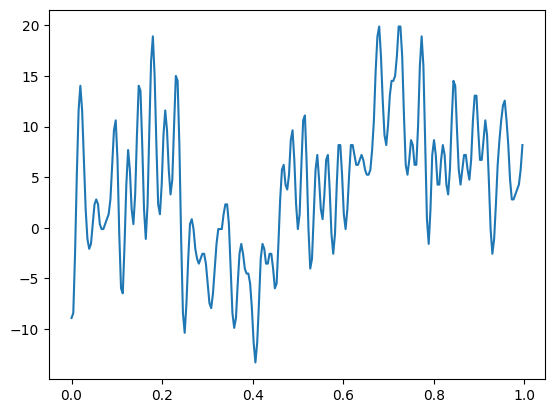

In [ ]:
# Examining one channel
oneSensor = TrueCrimeSubjectZero[TrueCrimeSubjectZero['sensor position'] == 'Fp1']

time = oneSensor['time']
sensorValue = oneSensor['sensor value']

plt.plot(time,sensorValue)
plt.show()

256


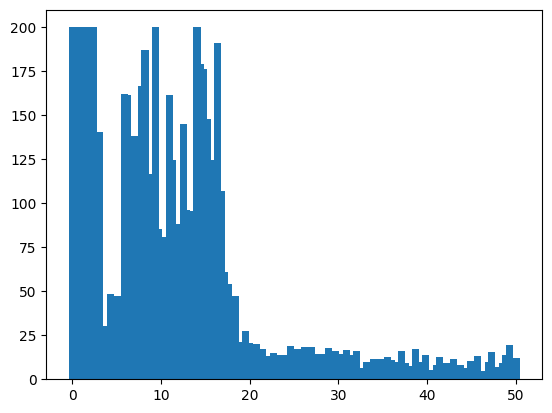

In [ ]:
## different freq band extraction
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 256 * 1 # 256 htz for one second

yf = abs(fft(sensorValue.astype(np.int64)))
PowerFilterIndex =  np.where(yf >= 200)[0]
#yf = np.delete(yf,PowerFilterIndex)
yf[PowerFilterIndex] = 200

variance = np.std(yf)**2
#fft_power = variance * abs(yf)

N = len(yf)

xf = abs(fftfreq(N, 1 / 100))

print(len(yf))
# Values above 60 htz are removed they are likely noise generated by electrical devices

plt.bar(xf, yf)
plt.show()

#  Wavelet analysis with PyWavelets
a Continuous Wavelet Transform (CWT) on an EEG signal using PyWavelets to visualize the time-frequency representation and ploting the wavelet scaleogram.

<ipython-input-35-23c3874d3350>:21: RuntimeWarning: divide by zero encountered in log2
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)


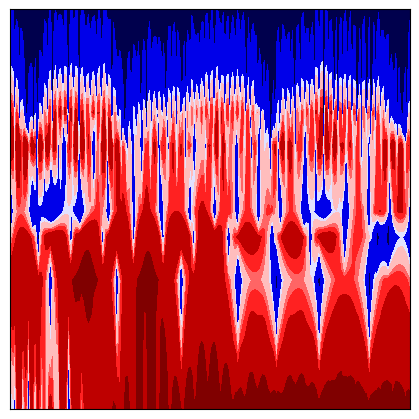

In [ ]:
t = 0.5
time = np.arange(0,256,1)
scales = [0.1,4.3,7.3,21.3,32,64,512]
x = yf
signal = sensorValue

def plot_wavelet(ax, time, signal, scales, waveletname = 'morl',
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):

    dt = 0.5

    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    #print(frequencies.max())
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    #levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    levels = [0.1,4.3,7.3,21.3,32,64,512]

    contourlevels = np.log2(levels)

    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)

    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)

    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    #ax.set_yticks(np.log2(yticks))
    #ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

#scales = [1,2,4,8,16]#np.arange(1, 256)

fig, ax = plt.subplots(figsize=(4, 4))
plot_wavelet(ax, time, signal, scales, xlabel='', ylabel='', title='')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.margins(x=0,y=0)
plt.tight_layout(pad=0, rect=(0,0,0,0))
plt.show()

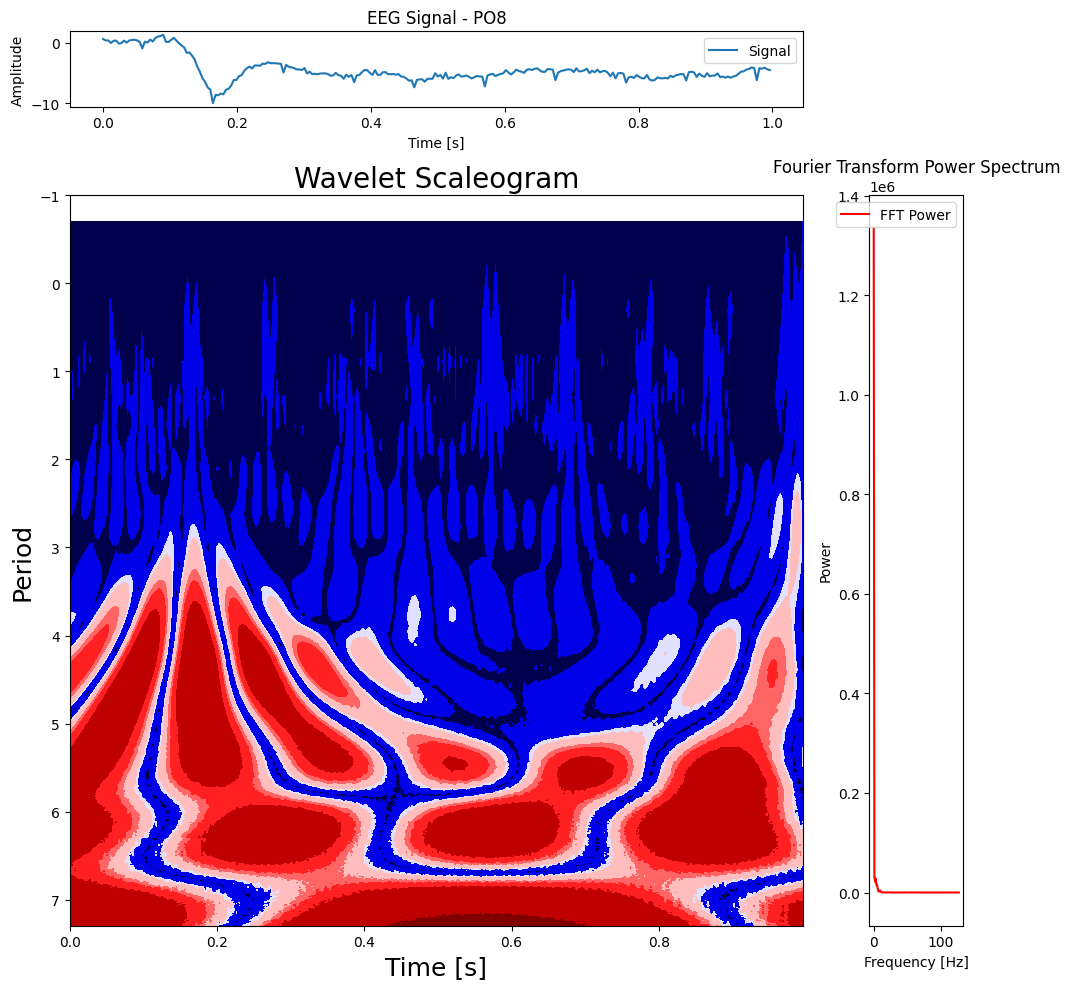

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.fft import fft, fftfreq
from matplotlib import gridspec

# Load the EEG data
eeg_data_path = '/content/drive/MyDrive/Colab_Notebooks/EEG_data_pivoted.csv'  # Replace with your file path
eeg_data = pd.read_csv(eeg_data_path)

# Clean column names
eeg_data.columns = eeg_data.columns.str.strip()

# Select the electrode and corresponding signal (e.g., 'AF3')
electrode = 'PO8'
time = eeg_data['time']
signal = eeg_data[electrode].values  # Convert to NumPy array

# Perform Continuous Wavelet Transform (CWT)
scales = np.arange(1, 256)
coef, freqs = pywt.cwt(signal, scales, 'morl')

# Perform Fourier Transform
n = len(signal)
yf = fft(signal)
xf = fftfreq(n, 1 / 256)[:n // 2]  # Assuming sampling rate of 256 Hz

# Define the plot_wavelet function
def plot_wavelet(ax, time, signal, scales, waveletname='morl', cmap=plt.cm.seismic, title='', ylabel='', xlabel=''):
    dt = 0.5
    coefficients, frequencies = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.1, 4.3, 7.3, 21.3, 32, 64, 512]
    contourlevels = np.log2(levels)
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap=cmap)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

# Plotting the signal, wavelet scaleogram, and Fourier transform in one figure
fig = plt.figure(figsize=(10, 10))
spec = gridspec.GridSpec(ncols=6, nrows=6)

# Plot original signal
top_ax = fig.add_subplot(spec[0, 0:5])
top_ax.plot(time, signal, label='Signal')
top_ax.set_title(f'EEG Signal - {electrode}')
top_ax.set_xlabel('Time [s]')
top_ax.set_ylabel('Amplitude')
top_ax.legend()

# Plot wavelet scaleogram
bottom_left_ax = fig.add_subplot(spec[1:, 0:5])
plot_wavelet(bottom_left_ax, time, signal, scales, title='Wavelet Scaleogram', xlabel='Time [s]', ylabel='Period')

# Plot Fourier Transform power spectrum
bottom_right_ax = fig.add_subplot(spec[1:, 5])
bottom_right_ax.plot(xf, np.abs(yf[:n // 2])**2, color='red', label='FFT Power')
bottom_right_ax.set_title('Fourier Transform Power Spectrum')
bottom_right_ax.set_xlabel('Frequency [Hz]')
bottom_right_ax.set_ylabel('Power')
bottom_right_ax.legend()

plt.tight_layout()
plt.show()


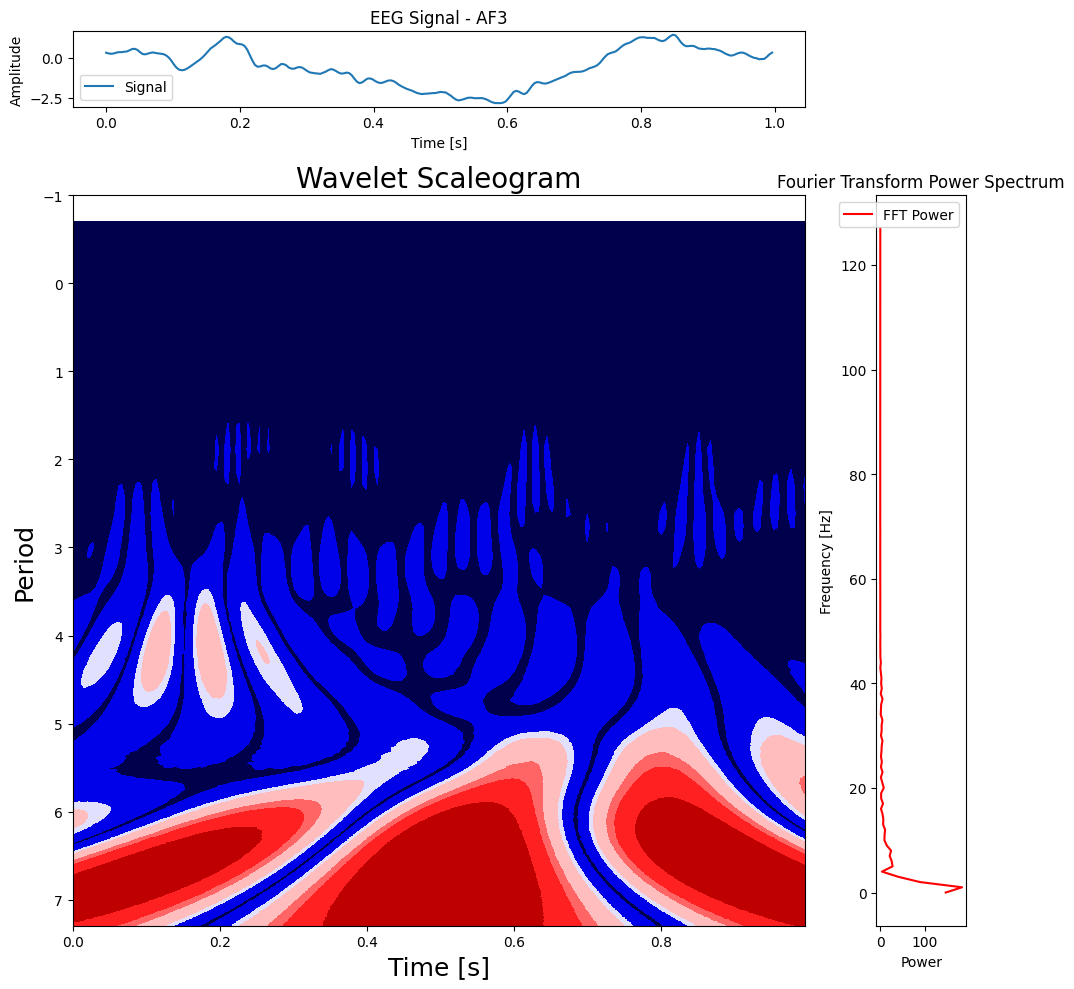

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.fft import fft, fftfreq
from matplotlib import gridspec

# Load the EEG data
eeg_data_path = '/content/drive/MyDrive/Colab_Notebooks/EEG_data_pivoted.csv'  # Replace with your file path
eeg_data = pd.read_csv(eeg_data_path)

# Clean column names
eeg_data.columns = eeg_data.columns.str.strip()

# Select the electrode and corresponding signal (e.g., 'AF3')
electrode = 'AF3'
time = eeg_data['time']
signal = eeg_data[electrode].values  # Convert to NumPy array

# Perform Continuous Wavelet Transform (CWT)
scales = np.arange(1, 256)
coef, freqs = pywt.cwt(signal, scales, 'morl')

# Perform Fourier Transform
n = len(signal)
yf = fft(signal)
xf = fftfreq(n, 1 / 256)[:n // 2]  # Assuming sampling rate of 256 Hz

# Define the plot_wavelet function
def plot_wavelet(ax, time, signal, scales, waveletname='morl',
                 cmap=plt.cm.seismic, title='', ylabel='', xlabel=''):
    dt = 0.5
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.1, 4.3, 7.3, 21.3, 32, 64, 512]
    contourlevels = np.log2(levels)

    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap=cmap)

    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)

    yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

# Plotting the original signal, wavelet scaleogram, and Fourier Transform power spectrum in one figure
fig = plt.figure(figsize=(10, 10))
spec = gridspec.GridSpec(ncols=6, nrows=6)

# Plot original signal
top_ax = fig.add_subplot(spec[0, 0:5])
top_ax.plot(time, signal, label='Signal')
top_ax.set_title(f'EEG Signal - {electrode}')
top_ax.set_xlabel('Time [s]')
top_ax.set_ylabel('Amplitude')
top_ax.legend()

# Plot wavelet scaleogram
bottom_left_ax = fig.add_subplot(spec[1:, 0:5])
plot_wavelet(bottom_left_ax, time, signal, scales, title='Wavelet Scaleogram', xlabel='Time [s]', ylabel='Period')

# Plot Fourier Transform power spectrum
bottom_right_ax = fig.add_subplot(spec[1:, 5])
bottom_right_ax.plot(np.abs(yf[:n // 2]), xf, color='red', label='FFT Power')
bottom_right_ax.set_title('Fourier Transform Power Spectrum')
bottom_right_ax.set_xlabel('Power')
bottom_right_ax.set_ylabel('Frequency [Hz]')
bottom_right_ax.legend()

plt.tight_layout()
plt.show()


# Channel clustering using hierarchical clustering
Calculates a correlation matrix between EEG channels and performs hierarchical clustering to group similar channels based on their correlation.

In [ ]:
# Step 2 Analyse Channels by means of hierarchical clustering

# Calculating the similarities in the time series,
# Grouping together

#Functions

def cluster_channels(distance_matrix,num_of_clusters):

  def hierarchical_clustering(dist_mat, method='ward'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)

    # Plotted visualization

    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()

In [ ]:
# Install necessary packages
!pip install scipy
from scipy.cluster.hierarchy import ward, complete, single, average, dendrogram, fcluster
import numpy as np
import random  # Import random for random sampling

# Function for clustering channels
def cluster_channels(distance_matrix, num_of_clusters):
    def hierarchical_clustering(dist_mat, method='ward'):
        if method == 'complete':
            Z = complete(distance_matrix)
        if method == 'single':
            Z = single(distance_matrix)
        if method == 'average':
            Z = average(distance_matrix)
        if method == 'ward':
            Z = ward(distance_matrix)

        # Dendrogram visualization (commented out)
        # fig = plt.figure(figsize=(16, 8))
        # dn = dendrogram(Z)
        # plt.title(f"Dendrogram for {method}-linkage with correlation distance")
        # plt.show()

        return Z

    linkage_matrix = hierarchical_clustering(distance_matrix)
    cluster_labels = fcluster(linkage_matrix, num_of_clusters, criterion='maxclust')
    return cluster_labels

# Function to select clusters
def select_clusters(cluster_index, totalFramesToInclude=1):  # Set totalFramesToInclude to 1
    unique_clusters = np.unique(cluster_index)
    unique_clusters_count = np.unique(cluster_index, return_counts=True)[1]

    unique, count = np.unique(cluster_index, return_counts=True)
    count_sort_ind = np.argsort(-count)
    size_sorted_clusters = unique[count_sort_ind]

    # Include all clusters larger than or equal to 1
    largerClusters = [k for k, v in enumerate(size_sorted_clusters) if v >= 1]

    # Remove zero from index
    largerClusters = [x for x in largerClusters if not x == 0]
    largerClusters = sorted(largerClusters)

    # Adjust selection logic for totalFramesToInclude = 1
    if len(largerClusters) == totalFramesToInclude:
        final_clusters = largerClusters
    elif len(largerClusters) > totalFramesToInclude:
        largerClusters = sorted(largerClusters)[:totalFramesToInclude]
    elif len(largerClusters) < totalFramesToInclude:
        sizeOneClusters = list(set(unique_clusters).difference(largerClusters))
        numToRandSelect = totalFramesToInclude - len(largerClusters)
        random_small_clusters = random.sample(sizeOneClusters, numToRandSelect)
        largerClusters = largerClusters + random_small_clusters
    else:
        raise Exception('Size error')

    if len(largerClusters) != totalFramesToInclude:
        print('Not OK')

    print(len(largerClusters))
    final_clusters = np.array(largerClusters)
    return final_clusters

# Function to select channels to transform
def select_channels_to_transform(trial_index, clusters_index, final_clusters_index):
    """
    Outputs indices of the channels that will be called out of the 64 Channel EEG frame.
    """
    finalChannelsIndex = {}

    for i in np.nditer(final_clusters_index):
        timeSeriesIndices = np.where(clusters_index == i)[0]
        if timeSeriesIndices.shape[0] == 0:
            print(len(timeSeriesIndices))

        randomSelectionIndex = np.random.choice(timeSeriesIndices)
        finalChannelsIndex[randomSelectionIndex] = i

    return finalChannelsIndex

# Additional logic to handle 8 persons with 64 electrodes each
def generate_wavelet_images_for_persons(person_count=8, electrode_count=61):
    for person in range(person_count):
        for electrode in range(electrode_count):
            # Replace with the actual code to generate wavelet images for each electrode
            print(f"Generating wavelet image for Person {person+1}, Electrode {electrode+1}")

generate_wavelet_images_for_persons()


Generating wavelet image for Person 1, Electrode 1
Generating wavelet image for Person 1, Electrode 2
Generating wavelet image for Person 1, Electrode 3
Generating wavelet image for Person 1, Electrode 4
Generating wavelet image for Person 1, Electrode 5
Generating wavelet image for Person 1, Electrode 6
Generating wavelet image for Person 1, Electrode 7
Generating wavelet image for Person 1, Electrode 8
Generating wavelet image for Person 1, Electrode 9
Generating wavelet image for Person 1, Electrode 10
Generating wavelet image for Person 1, Electrode 11
Generating wavelet image for Person 1, Electrode 12
Generating wavelet image for Person 1, Electrode 13
Generating wavelet image for Person 1, Electrode 14
Generating wavelet image for Person 1, Electrode 15
Generating wavelet image for Person 1, Electrode 16
Generating wavelet image for Person 1, Electrode 17
Generating wavelet image for Person 1, Electrode 18
Generating wavelet image for Person 1, Electrode 19
Generating wavelet im

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fig2data(fig):
    """
    Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it.
    @param fig: a matplotlib figure
    @return: a numpy 3D array of RGBA values
    """
    # Draw the renderer
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (h, w, 4)

    # Convert ARGB to RGBA
    buf = np.roll(buf, 3, axis=2)
    return buf

# Loop over each unique cluster
for cluster in np.unique(cluster_labels):
    print(f'#################### New cluster {cluster} ################')

    # Loop over each channel in Alc_Example
    for channel in Alc_Example.index:
        if cluster_labels[channel] == cluster:
            print(f'Cluster: {cluster}, Channel: {channel}')
            signal = Alc_Example.loc[channel]  # Extract the signal for the current channel
            x = signal

            fig, ax = plt.subplots(figsize=(3, 3))
            plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.margins(x=0, y=0)
            plt.tight_layout(pad=0, rect=(0, 0, 0, 0))

            # Convert the figure to a NumPy array
            np_array = fig2data(fig)

            # Show the plot (optional, for debugging or visual checking)
            plt.show()

            # Add logic for saving or further processing np_array if needed
            # Example: Save np_array as an image or store it in a dataset

            # Close the figure to free up memory
            plt.close(fig)


NameError: name 'cluster_labels' is not defined

#################### New cluster 1 ################
Cluster: 1, Channel: 32


<ipython-input-35-23c3874d3350>:21: RuntimeWarning: divide by zero encountered in log2
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)


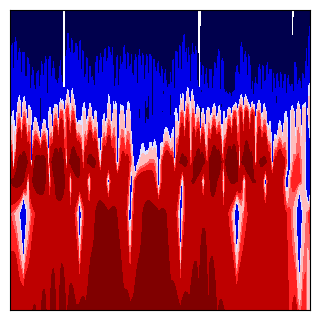

#################### New cluster 2 ################
Cluster: 2, Channel: 35


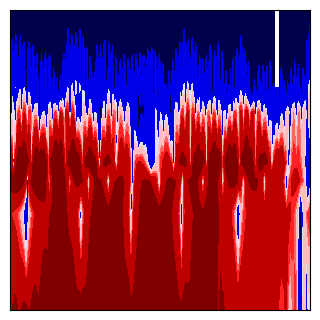

#################### New cluster 3 ################
Cluster: 3, Channel: 58


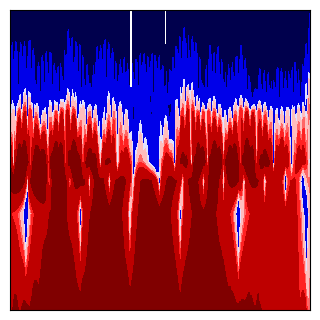

#################### New cluster 4 ################
Cluster: 4, Channel: 30


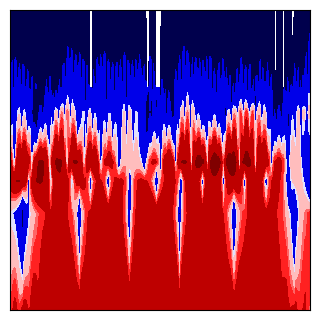

#################### New cluster 5 ################
Cluster: 5, Channel: 31


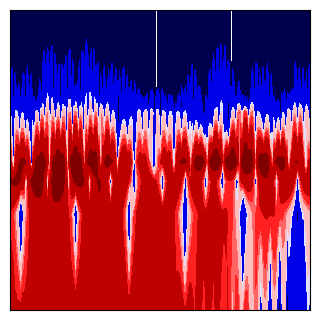

#################### New cluster 6 ################
Cluster: 6, Channel: 34


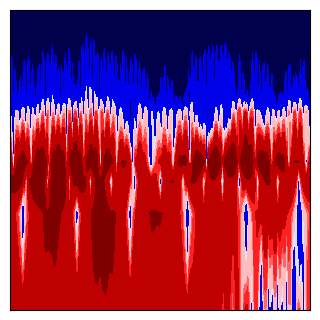

#################### New cluster 7 ################
Cluster: 7, Channel: 29


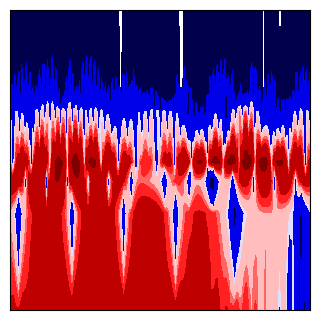

#################### New cluster 8 ################
Cluster: 8, Channel: 23


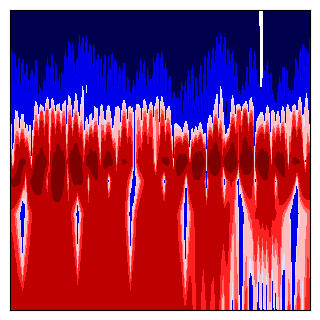

#################### New cluster 9 ################
Cluster: 9, Channel: 25


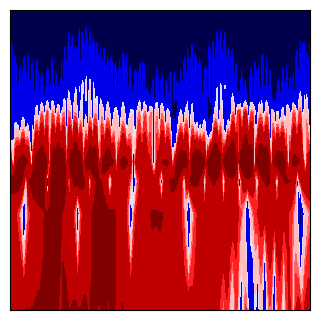

#################### New cluster 10 ################
Cluster: 10, Channel: 2


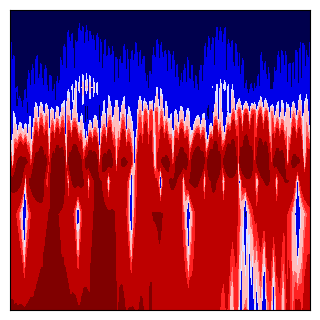

#################### New cluster 11 ################
Cluster: 11, Channel: 18


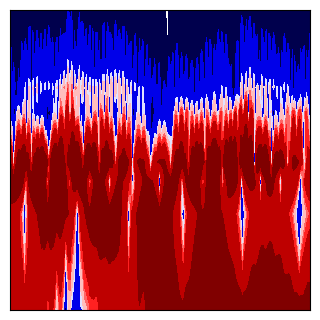

#################### New cluster 12 ################
Cluster: 12, Channel: 20


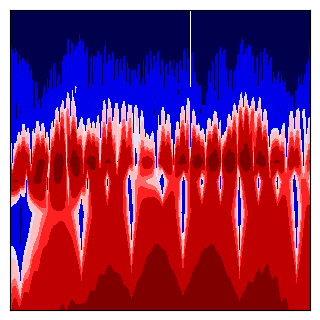

#################### New cluster 13 ################
Cluster: 13, Channel: 39


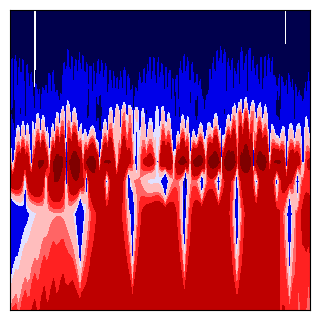

#################### New cluster 14 ################
Cluster: 14, Channel: 28


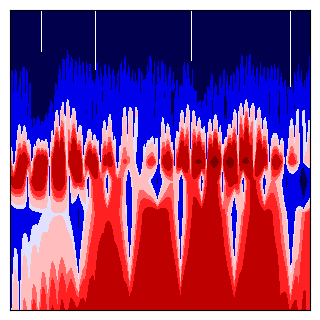

#################### New cluster 15 ################
Cluster: 15, Channel: 22


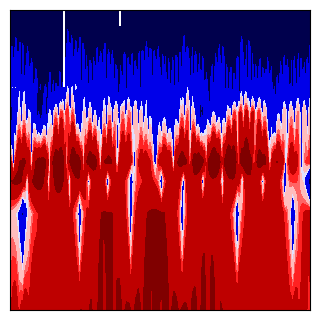

Cluster: 15, Channel: 24


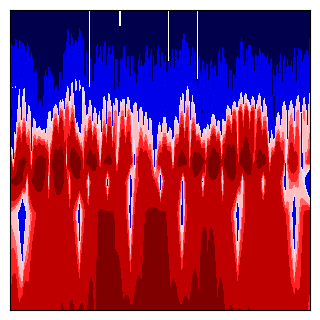

#################### New cluster 16 ################
Cluster: 16, Channel: 3


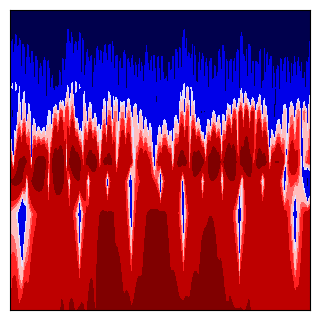

#################### New cluster 17 ################
Cluster: 17, Channel: 26


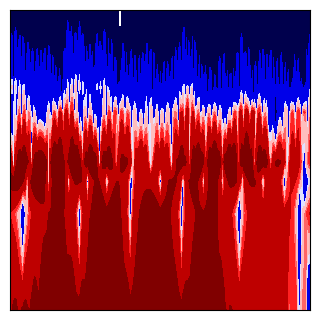

#################### New cluster 18 ################
Cluster: 18, Channel: 0


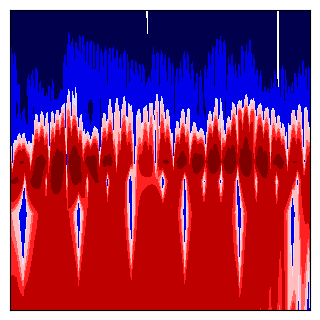

#################### New cluster 19 ################
Cluster: 19, Channel: 1


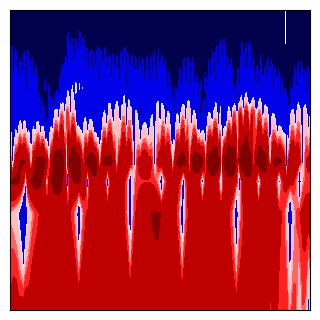

#################### New cluster 20 ################
Cluster: 20, Channel: 37


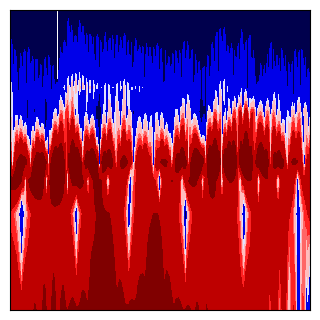

Cluster: 20, Channel: 38


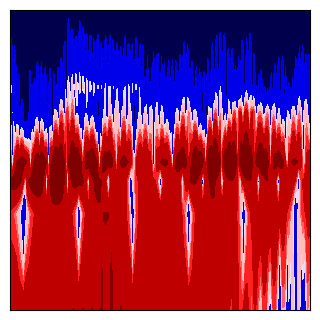

#################### New cluster 21 ################
Cluster: 21, Channel: 36


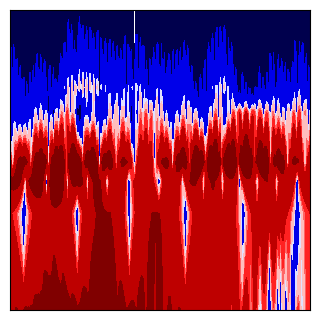

#################### New cluster 22 ################
Cluster: 22, Channel: 4


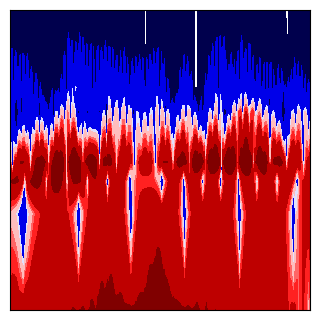

#################### New cluster 23 ################
Cluster: 23, Channel: 19


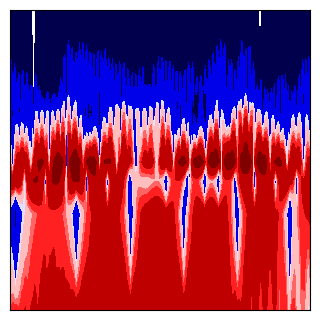

#################### New cluster 24 ################
Cluster: 24, Channel: 21


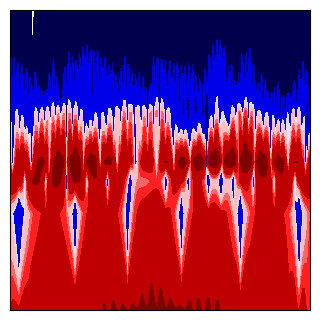

#################### New cluster 25 ################
Cluster: 25, Channel: 27


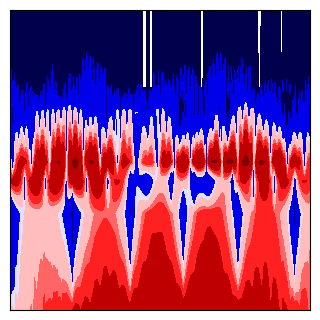

#################### New cluster 26 ################
Cluster: 26, Channel: 33


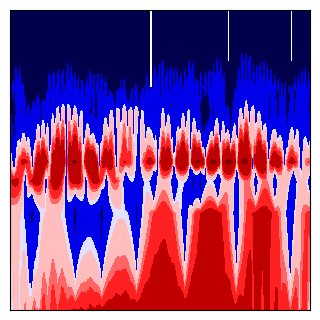

#################### New cluster 27 ################
Cluster: 27, Channel: 12


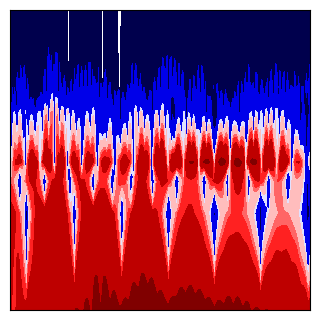

#################### New cluster 28 ################
Cluster: 28, Channel: 56


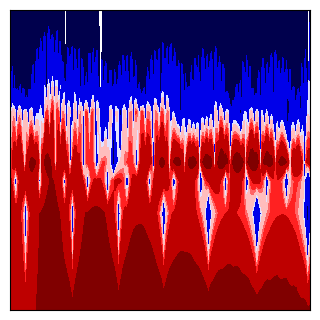

#################### New cluster 29 ################
Cluster: 29, Channel: 11


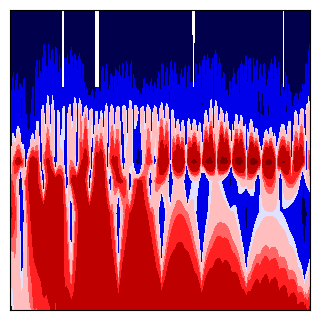

#################### New cluster 30 ################
Cluster: 30, Channel: 17


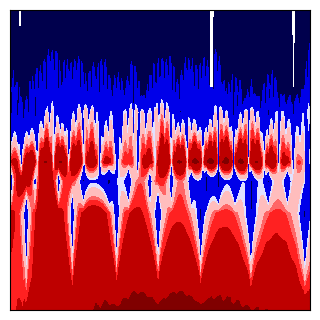

#################### New cluster 31 ################
Cluster: 31, Channel: 10


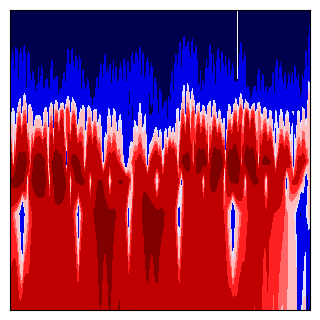

#################### New cluster 32 ################
Cluster: 32, Channel: 60


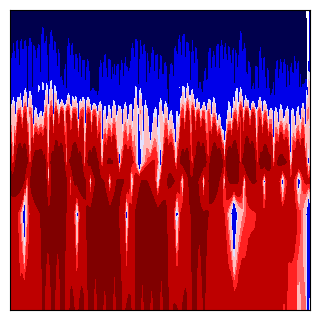

#################### New cluster 33 ################
Cluster: 33, Channel: 9


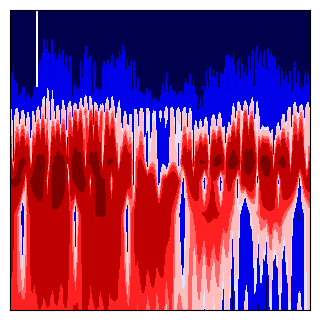

#################### New cluster 34 ################
Cluster: 34, Channel: 59


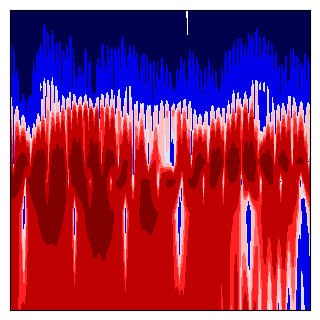

#################### New cluster 35 ################
Cluster: 35, Channel: 57


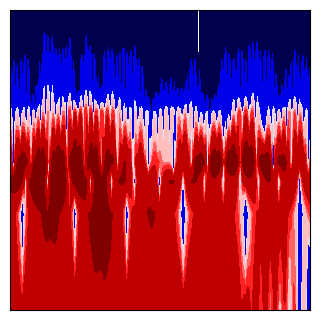

#################### New cluster 36 ################
Cluster: 36, Channel: 40


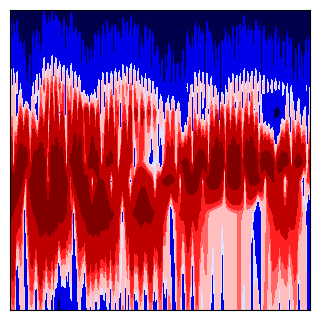

#################### New cluster 37 ################
Cluster: 37, Channel: 53


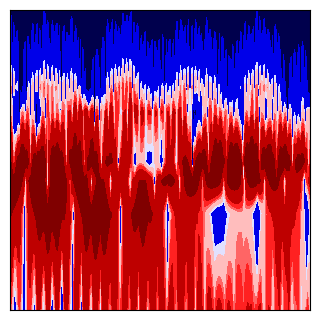

#################### New cluster 38 ################
Cluster: 38, Channel: 49


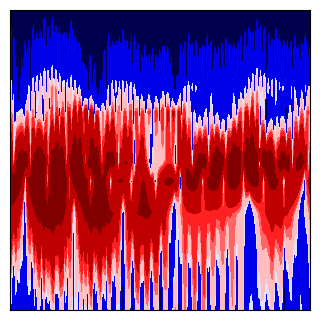

#################### New cluster 39 ################
Cluster: 39, Channel: 15


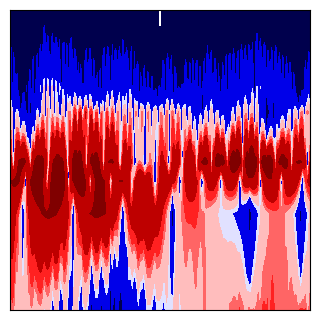

#################### New cluster 40 ################
Cluster: 40, Channel: 50


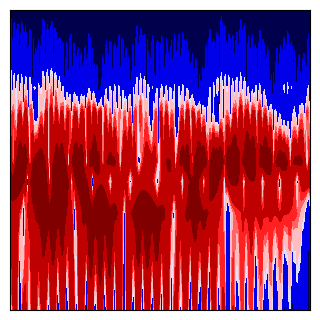

#################### New cluster 41 ################
Cluster: 41, Channel: 54


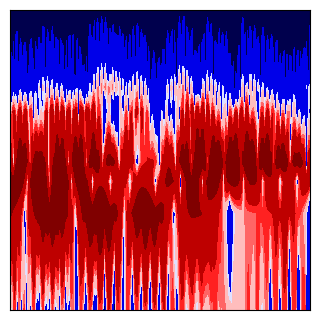

#################### New cluster 42 ################
Cluster: 42, Channel: 16


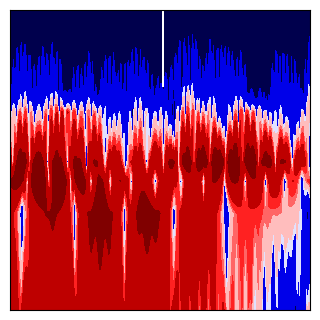

#################### New cluster 43 ################
Cluster: 43, Channel: 41


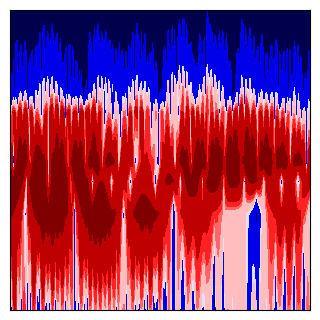

#################### New cluster 44 ################
Cluster: 44, Channel: 42


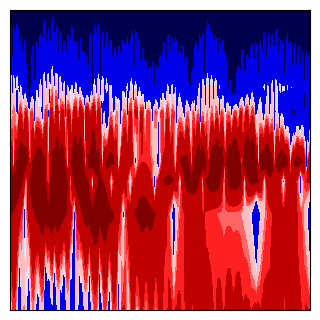

#################### New cluster 45 ################
Cluster: 45, Channel: 48


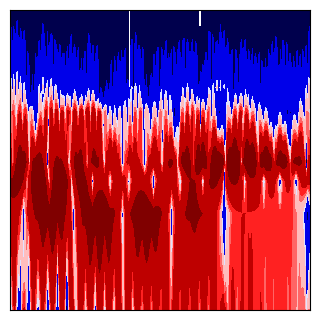

#################### New cluster 46 ################
Cluster: 46, Channel: 5


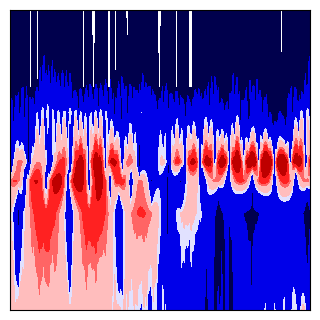

#################### New cluster 47 ################
Cluster: 47, Channel: 7


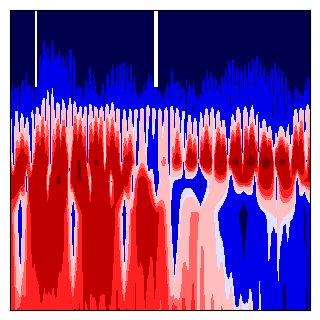

#################### New cluster 48 ################
Cluster: 48, Channel: 13


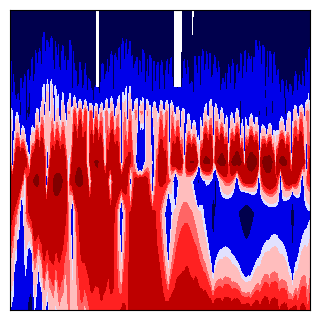

#################### New cluster 49 ################
Cluster: 49, Channel: 45


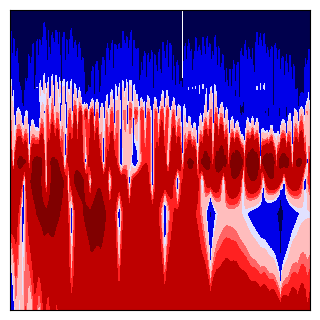

#################### New cluster 50 ################
Cluster: 50, Channel: 43


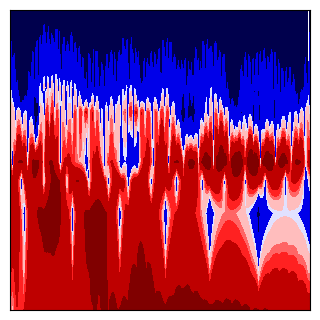

#################### New cluster 51 ################
Cluster: 51, Channel: 44


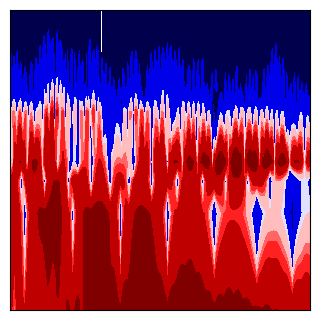

#################### New cluster 52 ################
Cluster: 52, Channel: 46


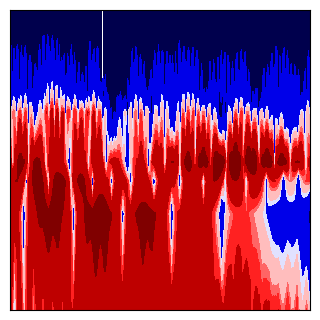

#################### New cluster 53 ################
Cluster: 53, Channel: 52


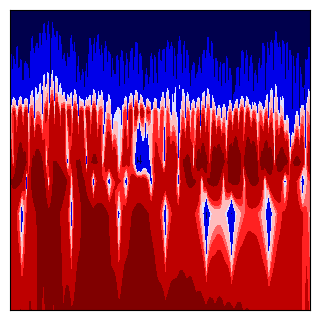

#################### New cluster 54 ################
Cluster: 54, Channel: 14


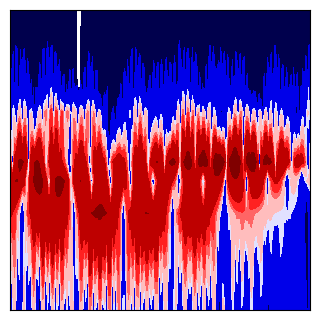

#################### New cluster 55 ################
Cluster: 55, Channel: 51


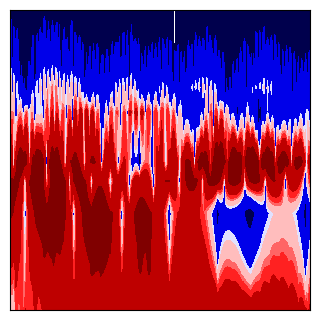

#################### New cluster 56 ################
Cluster: 56, Channel: 55


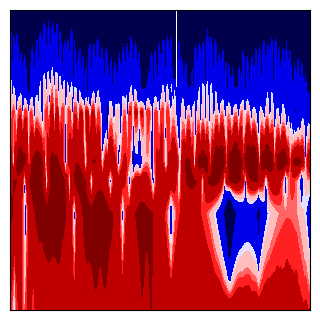

#################### New cluster 57 ################
Cluster: 57, Channel: 47


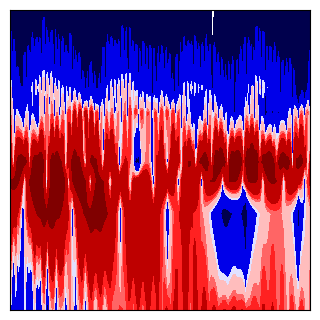

#################### New cluster 58 ################
Cluster: 58, Channel: 6


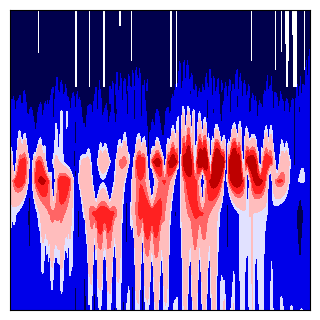

#################### New cluster 59 ################
Cluster: 59, Channel: 8


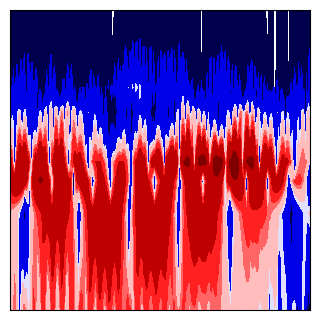

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, complete, single, average, dendrogram, fcluster

# Assume EEG_data_pivoted is already defined and contains the EEG data
# Calculate the correlation matrix
distance_matrix = np.corrcoef(EEG_data_pivoted.T)  # Transpose to correlate channels
num_of_clusters = 64  # Number of clusters you want
cluster_labels = cluster_channels(distance_matrix, num_of_clusters)

# Function to convert a Matplotlib figure to a 4D numpy array with RGBA channels
def fig2data(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (h, w, 4)
    buf = np.roll(buf, 3, axis=2)  # Convert ARGB to RGBA
    return buf

# Iterate over the clusters and channels
for cluster in np.unique(cluster_labels):
    print(f'#################### New cluster {cluster} ################')

    for channel in range(len(cluster_labels)):  # Assuming channel is indexed by integers
        if cluster_labels[channel] == cluster:
            print(f'Cluster: {cluster}, Channel: {channel}')
            signal = EEG_data_pivoted.iloc[:, channel].values  # Access the signal values

            # Plot wavelet for the current channel
            fig, ax = plt.subplots(figsize=(3, 3))
            plot_wavelet(ax, time, signal, scales, xlabel='', ylabel='', title='')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.margins(x=0, y=0)
            plt.tight_layout(pad=0, rect=(0, 0, 0, 0))

            # Convert the figure to a numpy array
            np_array = fig2data(fig)

            # Show the plot (optional, can be commented out if not needed)
            plt.show()

            # Close the figure to free up memory
            plt.close(fig)


Peeking at the data: Looking at each cluster in a print test
These graphs show time, and frequency data visualized in two dimensions

The bottom area of the chart has low resolution information the low frequencies that don't change often.

The top areas of the chart have higher resolution information on the high frequencies that do change more often.

Clustering the channels produced groups which had similar graphs
Cluster 2: 1
Cluster 3: 1
Cluster 4: 1
Cluster 5: 1
Cluster 6: 1
Cluster 7: 1
Cluster 8: 1
Cluster 9: 1
Cluster 10: 1
Cluster 11: 1
Cluster 12: 1
Cluster 13: 1
Cluster 14: 1
Cluster 15: 1
Cluster 16: 2
Cluster 17: 1
Cluster 18: 1
Cluster 19: 1
Cluster 20: 1
Cluster 21: 2
Cluster 22: 1
Cluster 23: 1
Cluster 24: 1
Cluster 25: 1
Cluster 26: 1
Cluster 27: 1
Cluster 28: 1
Cluster 29: 1
Cluster 30: 1
Cluster 31: 1
Cluster 32: 1
Cluster 33: 1
Cluster 34: 1
Cluster 35: 1
Cluster 36: 1
Cluster 37: 1
Cluster 38: 1
Cluster 39: 1
Cluster 40: 1
Cluster 41: 1
Cluster 42: 1
Cluster 43: 1
Cluster 44: 1
Cluster 45: 1
Cluster 46: 1
Cluster 47: 1
Cluster 48: 1
Cluster 49: 1
Cluster 50: 1
Cluster 51: 1
Cluster 52: 1
Cluster 53: 1
Cluster 54: 1
Cluster 55: 1
Cluster 56: 1
Cluster 57: 1
Cluster 58: 1
Cluster 59: 1
Cluster 60: 1
#################### New cluster 1 ################
Cluster 1, Channel 32


<ipython-input-35-23c3874d3350>:21: RuntimeWarning: divide by zero encountered in log2
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)


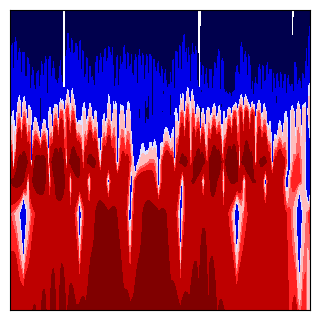

#################### New cluster 2 ################
Cluster 2, Channel 35


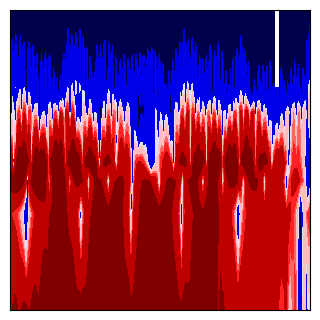

#################### New cluster 3 ################
Cluster 3, Channel 58


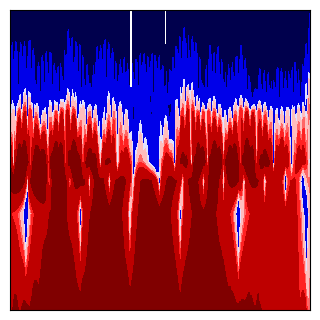

#################### New cluster 4 ################
Cluster 4, Channel 30


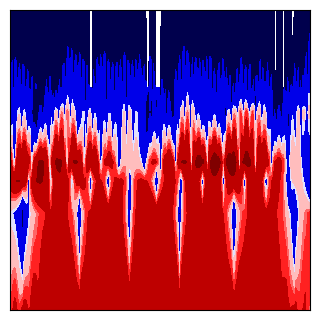

#################### New cluster 5 ################
Cluster 5, Channel 31


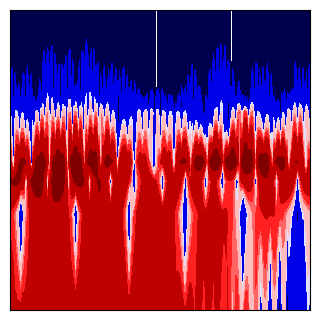

#################### New cluster 6 ################
Cluster 6, Channel 34


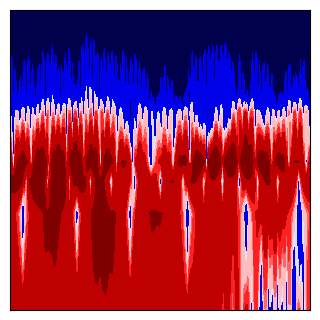

#################### New cluster 7 ################
Cluster 7, Channel 29


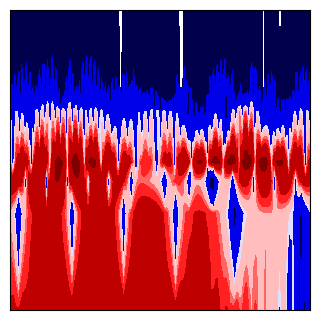

#################### New cluster 8 ################
Cluster 8, Channel 23


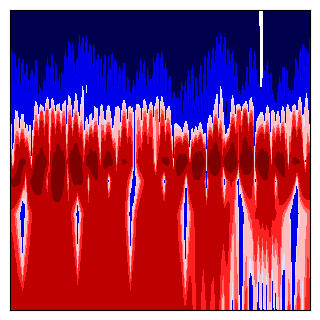

#################### New cluster 9 ################
Cluster 9, Channel 25


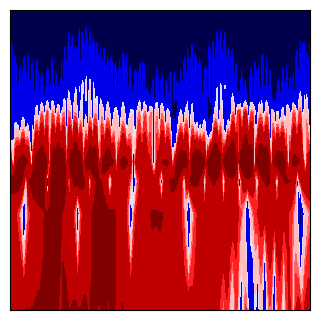

#################### New cluster 10 ################
Cluster 10, Channel 2


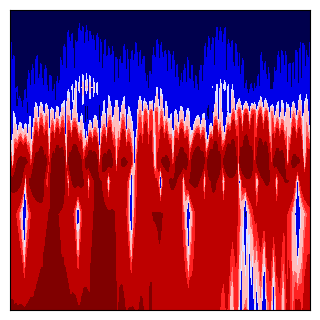

#################### New cluster 11 ################
Cluster 11, Channel 18


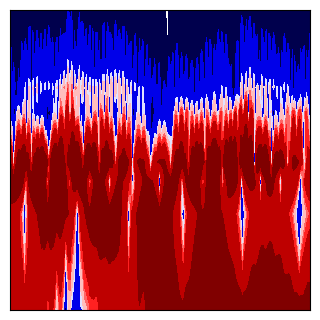

#################### New cluster 12 ################
Cluster 12, Channel 20


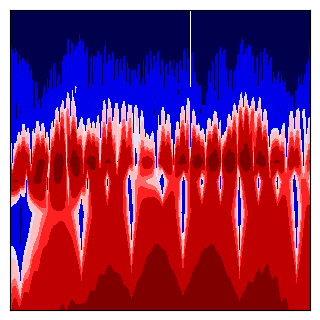

#################### New cluster 13 ################
Cluster 13, Channel 39


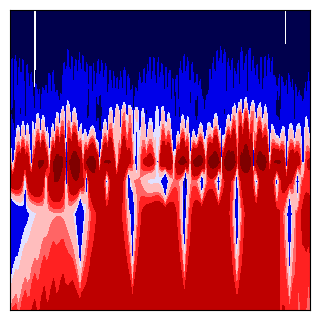

#################### New cluster 14 ################
Cluster 14, Channel 28


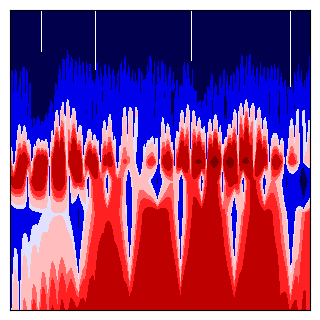

#################### New cluster 15 ################
Cluster 15, Channel 22


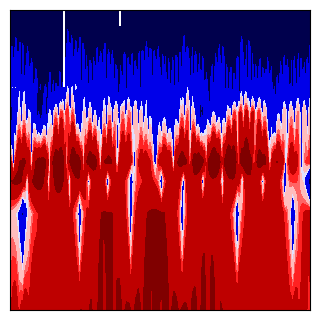

Cluster 15, Channel 24


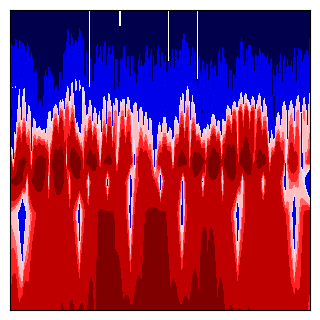

#################### New cluster 16 ################
Cluster 16, Channel 3


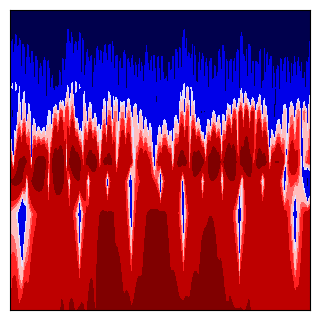

#################### New cluster 17 ################
Cluster 17, Channel 26


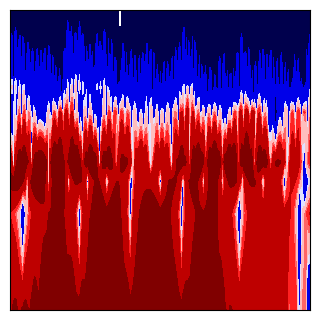

#################### New cluster 18 ################
Cluster 18, Channel 0


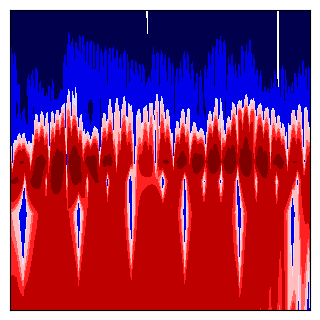

#################### New cluster 19 ################
Cluster 19, Channel 1


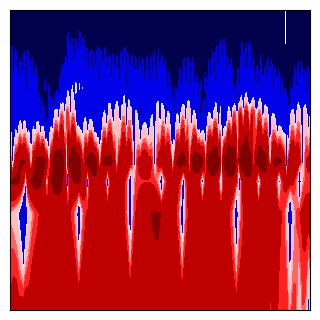

#################### New cluster 20 ################
Cluster 20, Channel 37


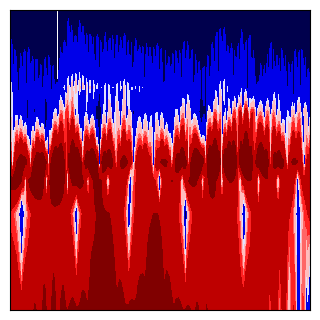

Cluster 20, Channel 38


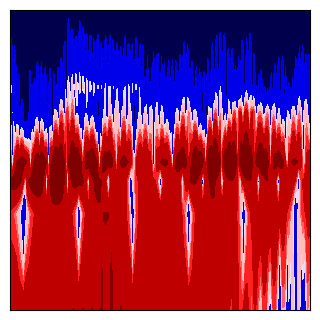

#################### New cluster 21 ################
Cluster 21, Channel 36


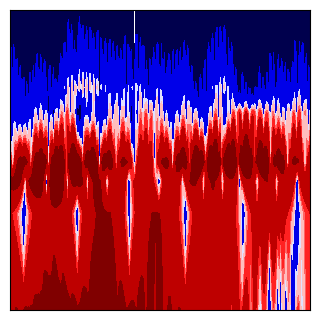

#################### New cluster 22 ################
Cluster 22, Channel 4


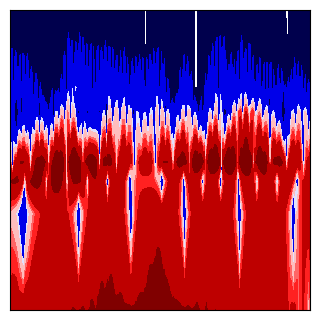

#################### New cluster 23 ################
Cluster 23, Channel 19


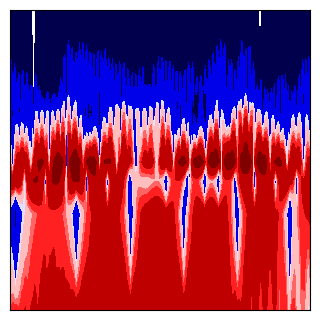

#################### New cluster 24 ################
Cluster 24, Channel 21


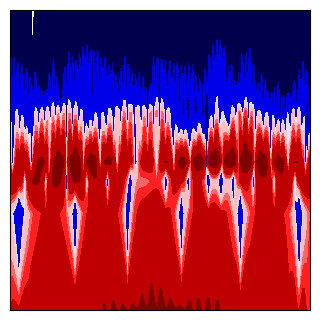

#################### New cluster 25 ################
Cluster 25, Channel 27


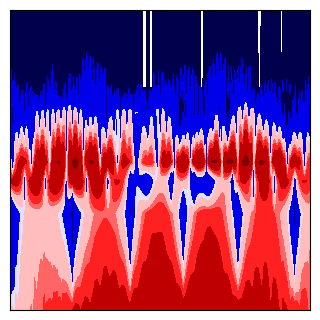

#################### New cluster 26 ################
Cluster 26, Channel 33


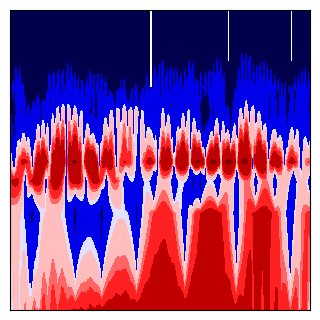

#################### New cluster 27 ################
Cluster 27, Channel 12


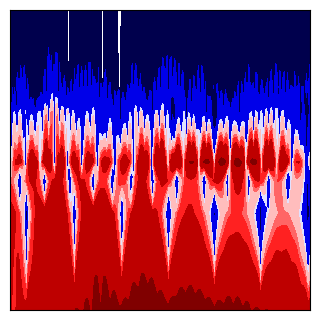

#################### New cluster 28 ################
Cluster 28, Channel 56


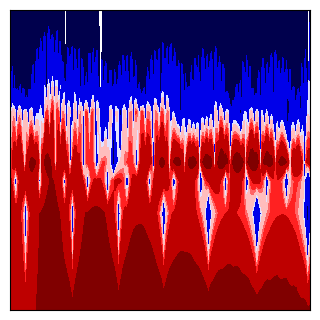

#################### New cluster 29 ################
Cluster 29, Channel 11


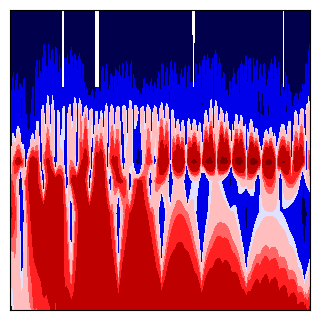

#################### New cluster 30 ################
Cluster 30, Channel 17


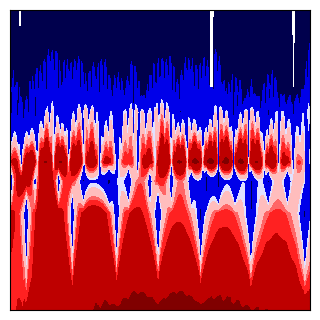

#################### New cluster 31 ################
Cluster 31, Channel 10


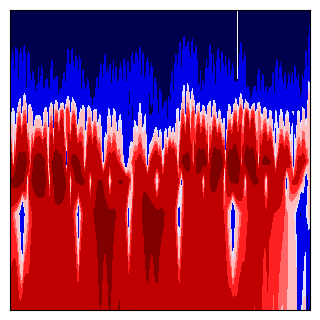

#################### New cluster 32 ################
Cluster 32, Channel 60


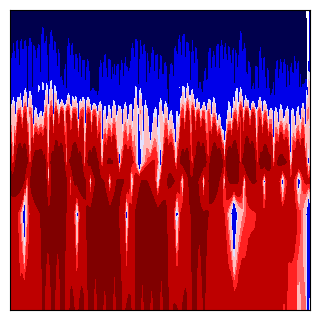

#################### New cluster 33 ################
Cluster 33, Channel 9


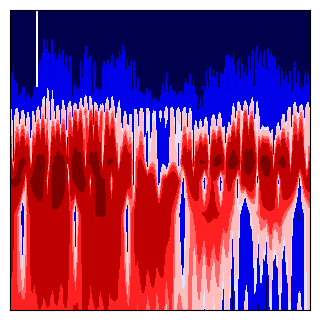

#################### New cluster 34 ################
Cluster 34, Channel 59


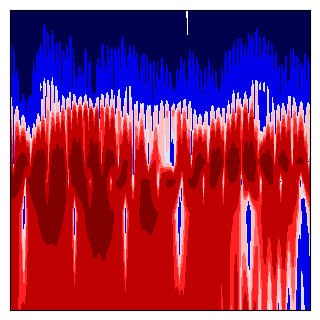

#################### New cluster 35 ################
Cluster 35, Channel 57


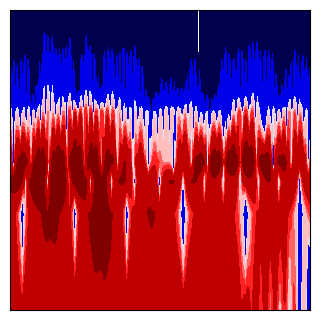

#################### New cluster 36 ################
Cluster 36, Channel 40


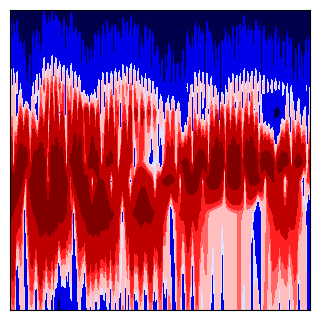

#################### New cluster 37 ################
Cluster 37, Channel 53


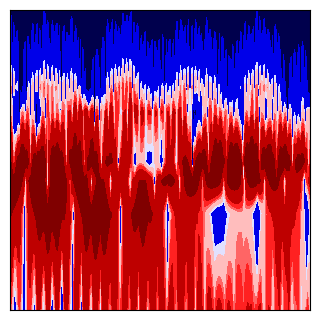

#################### New cluster 38 ################
Cluster 38, Channel 49


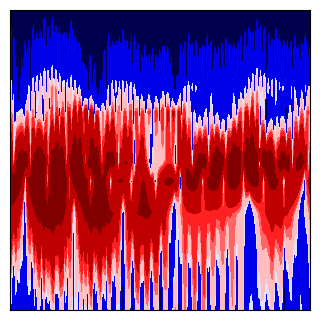

#################### New cluster 39 ################
Cluster 39, Channel 15


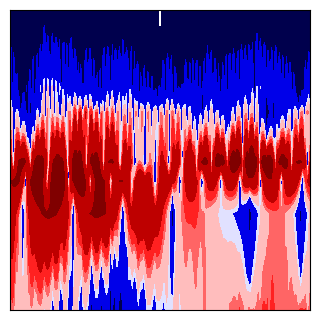

#################### New cluster 40 ################
Cluster 40, Channel 50


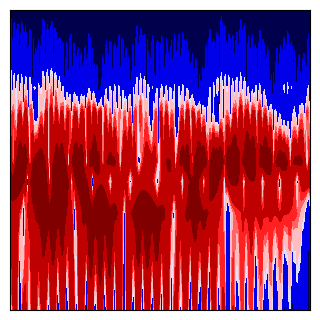

#################### New cluster 41 ################
Cluster 41, Channel 54


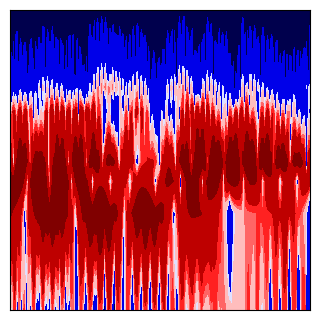

#################### New cluster 42 ################
Cluster 42, Channel 16


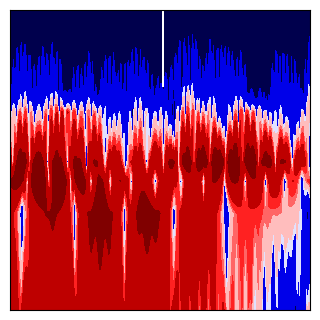

#################### New cluster 43 ################
Cluster 43, Channel 41


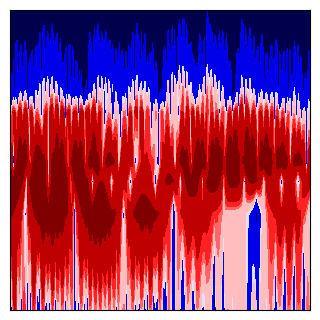

#################### New cluster 44 ################
Cluster 44, Channel 42


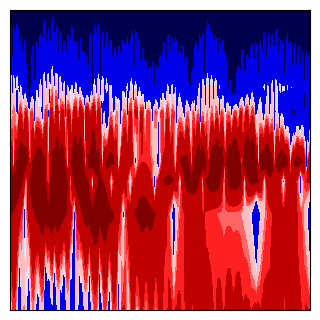

#################### New cluster 45 ################
Cluster 45, Channel 48


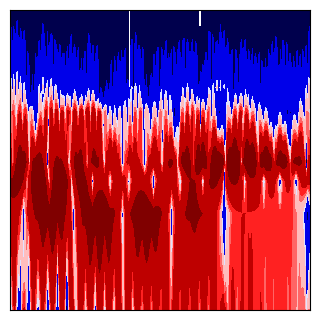

#################### New cluster 46 ################
Cluster 46, Channel 5


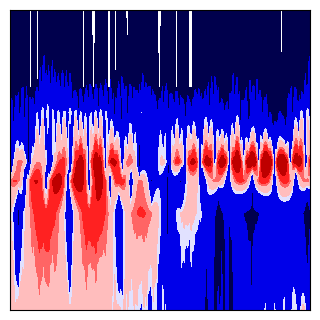

#################### New cluster 47 ################
Cluster 47, Channel 7


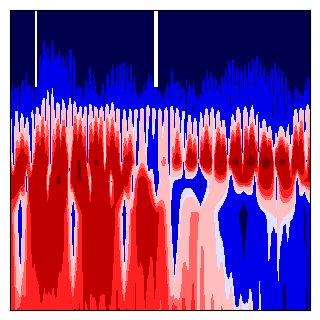

#################### New cluster 48 ################
Cluster 48, Channel 13


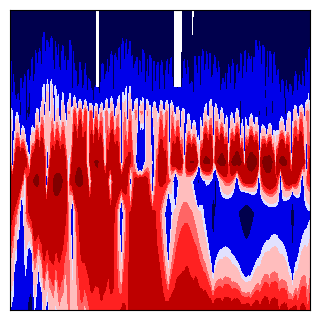

#################### New cluster 49 ################
Cluster 49, Channel 45


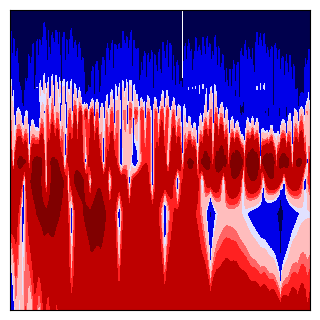

#################### New cluster 50 ################
Cluster 50, Channel 43


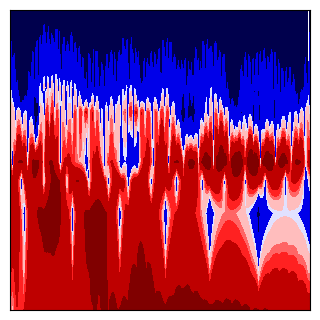

#################### New cluster 51 ################
Cluster 51, Channel 44


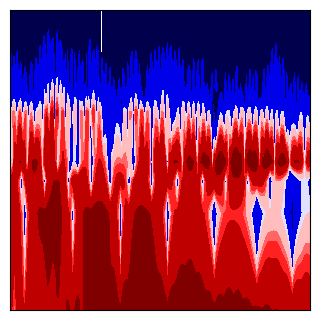

#################### New cluster 52 ################
Cluster 52, Channel 46


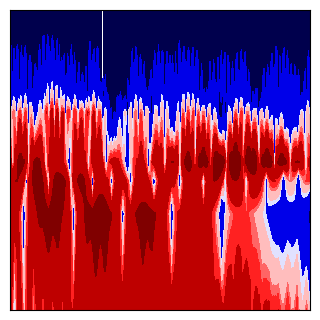

#################### New cluster 53 ################
Cluster 53, Channel 52


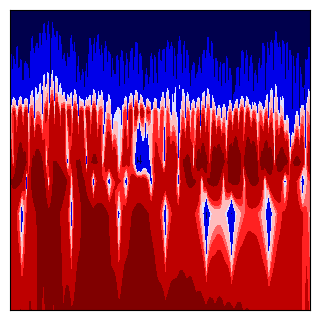

#################### New cluster 54 ################
Cluster 54, Channel 14


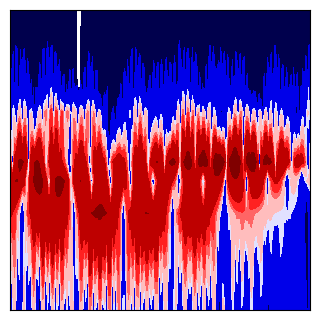

#################### New cluster 55 ################
Cluster 55, Channel 51


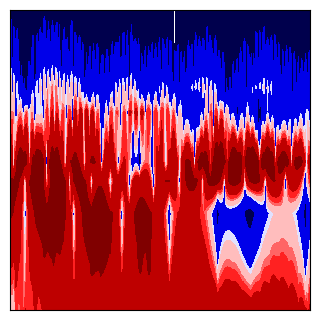

#################### New cluster 56 ################
Cluster 56, Channel 55


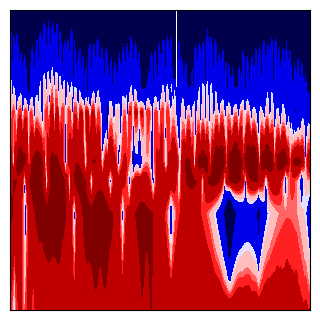

#################### New cluster 57 ################
Cluster 57, Channel 47


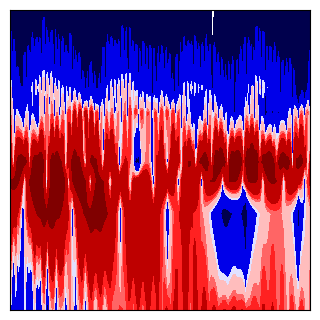

#################### New cluster 58 ################
Cluster 58, Channel 6


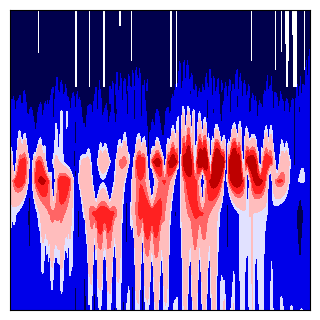

#################### New cluster 59 ################
Cluster 59, Channel 8


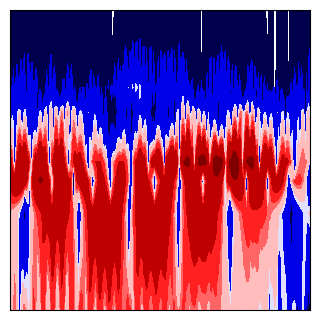

Clustering the channels produced groups which had similar graphs.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, complete, single, average, dendrogram, fcluster

# Calculate the correlation matrix
distance_matrix = np.corrcoef(EEG_data_pivoted.T)  # Transpose to correlate channels
num_of_clusters = 64  # Define the number of clusters
cluster_labels = cluster_channels(distance_matrix, num_of_clusters)

# Calculate and print the size of each cluster
cluster_sizes = np.bincount(cluster_labels)  # Compute the size of each cluster
print("Clustering the channels produced groups which had similar graphs")

for i, size in enumerate(cluster_sizes):
    if size > 0:
        print(f"Cluster {i + 1}: {size}")

# Function to convert a Matplotlib figure to a 4D numpy array with RGBA channels
def fig2data(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (h, w, 4)
    buf = np.roll(buf, 3, axis=2)  # Convert ARGB to RGBA
    return buf

# Iterate over each cluster and plot the wavelet graphs for the channels within the cluster
for cluster in np.unique(cluster_labels):
    print(f'#################### New cluster {cluster} ################')

    for channel in range(len(cluster_labels)):  # Loop over each channel
        if cluster_labels[channel] == cluster:
            print(f'Cluster {cluster}, Channel {channel}')
            signal = EEG_data_pivoted.iloc[:, channel].values  # Extract the signal for the channel

            # Create a new plot for each signal
            fig, ax = plt.subplots(figsize=(3, 3))
            plot_wavelet(ax, time, signal, scales, xlabel='', ylabel='', title='')  # Generate the wavelet plot
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.margins(x=0, y=0)
            plt.tight_layout(pad=0, rect=(0, 0, 0, 0))

            # Convert the figure to a numpy array
            np_array = fig2data(fig)

            # Show the plot
            plt.show()

            # Close the figure to free up memory
            plt.close(fig)

print("Clustering the channels produced groups which had similar graphs.")


#Feature Extraction code¶
Features to be extracted
Time (x) axis 0 to 255 samples 256htz¶
Y axis (Frequency) Bottom has low frequency,
Z (color, prevalence)

In [ ]:
def pull_one_second_frame(row, trial_index, input_data):
    """
    Extracts a one-second frame of EEG data from the input dataset.

    Args:
        row (int): The row index for a specific trial.
        trial_index (DataFrame): DataFrame containing 'trial number' and 'name' to match specific trials.
        input_data (DataFrame): Full dataset containing EEG data with columns 'trial number', 'name', 'channel', 'time', and 'sensor value'.

    Returns:
        DataFrame: A pivot table (64 channels by 256 time points) containing the EEG signal values for a specific one-second frame.
    """

    # Extract the trial number and name for the given row index
    trial_number = trial_index.loc[row]['trial number']
    name = trial_index.loc[row]['name']

    # Filter the input_data for the specified trial number and name
    filtered_data = input_data[(input_data['trial number'] == trial_number) &
                               (input_data['name'] == name)]

    # Create a pivot table with 'channel' as rows and 'time' as columns,
    # containing the 'sensor value' as values
    pivot_table = filtered_data.pivot_table(index='channel', columns='time', values='sensor value')

    return pivot_table


Part Two Feature Extraction of Wavelets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Import PyWavelets for wavelet transformations

def wavelet_transformation_plot_to_array(signal):
    """
    Performs a wavelet transformation on a signal, plots the wavelet power spectrum,
    and converts the plot to a NumPy array.

    Args:
        signal (array-like): The 1D signal data to be transformed and plotted.

    Returns:
        np.ndarray: A 4D NumPy array with RGBA values representing the plot.
    """
    # Define time and scale parameters for the wavelet transformation
    dt = 0.8  # Sampling interval
    time = np.arange(0, 256, 1)  # Time points
    scales = np.arange(1, 256)  # Wavelet scales

    def plot_wavelet(ax, time, signal, scales, waveletname='morl',
                     cmap=plt.cm.seismic, title='', ylabel='', xlabel=''):
        """
        Plots the wavelet transform of a signal on the provided axes.

        Args:
            ax (matplotlib.axes.Axes): The axes to plot on.
            time (array-like): Time points corresponding to the signal.
            signal (array-like): The signal to transform.
            scales (array-like): The scales to use in the wavelet transform.
            waveletname (str): The wavelet type.
            cmap (matplotlib.colors.Colormap): The colormap to use.
            title (str): The title of the plot.
            ylabel (str): The Y-axis label.
            xlabel (str): The X-axis label.

        Returns:
            yticks (array-like): Y-axis tick positions.
            ylim (tuple): Y-axis limits.
        """
        dt = time[1] - time[0]
        coefficients, frequencies = pywt.cwt(signal, scales, waveletname, dt)
        power = np.abs(coefficients) ** 2  # Compute power spectrum
        period = 1.0 / frequencies

        # Levels corresponding to different wavelengths of brain waves
        levels = [0.1, 4.3, 7.3, 21.3, 32, 64, 512]
        contourlevels = np.log2(levels)

        # Plot the wavelet power spectrum
        ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap=cmap)
        plt.ioff()  # Turn off interactive mode for plotting

        # Customize the plot's appearance
        yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)

        ax.invert_yaxis()
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0], -1)
        return yticks, ylim

    # Create the plot
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.ioff()  # Disable interactive mode to prevent automatic display
    plot_wavelet(ax, time, signal, scales, xlabel='', ylabel='', title='')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.margins(x=0, y=0)
    plt.tight_layout(pad=0, rect=(0, 0, 0, 0))

    # Convert the plot to a NumPy array
    def fig2data(fig):
        """
        Convert a Matplotlib figure to a 4D numpy array with RGBA channels.

        Args:
            fig (matplotlib.figure.Figure): The figure to convert.

        Returns:
            np.ndarray: A numpy 3D array of RGBA values.
        """
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
        buf.shape = (h, w, 4)  # Correct shape for the buffer
        buf = np.roll(buf, 3, axis=2)  # Convert ARGB to RGBA
        return buf

    # Close the plot to free memory
    plt.close(fig)
    output_array = fig2data(fig)

    return output_array


In [ ]:
def rgba2rgb(rgba, background=(255, 255, 255)):
    """
    Converts an RGBA image to an RGB image by blending with a specified background.

    Args:
        rgba (np.ndarray): The input RGBA image as a NumPy array with shape (height, width, 4).
        background (tuple): A tuple representing the RGB background color (default is white).

    Returns:
        np.ndarray: An RGB image as a NumPy array with shape (height, width, 3).
    """
    # Check image dimensions
    row, col, ch = rgba.shape

    # If already RGB, return as is
    if ch == 3:
        return rgba

    assert ch == 4, 'Input image must have 4 channels (RGBA).'

    # Initialize an RGB array
    rgb = np.zeros((row, col, 3), dtype='float32')

    # Extract individual channels
    r, g, b, a = rgba[:, :, 0], rgba[:, :, 1], rgba[:, :, 2], rgba[:, :, 3]

    # Normalize alpha channel to range [0, 1]
    a = a.astype('float32') / 255.0

    # Extract background color components
    R, G, B = background

    # Blend each channel with the background
    rgb[:, :, 0] = r * a + (1.0 - a) * R
    rgb[:, :, 1] = g * a + (1.0 - a) * G
    rgb[:, :, 2] = b * a + (1.0 - a) * B

    # Convert back to unsigned 8-bit integer format
    return rgb.astype('uint8')


In [ ]:
def name_image(trial, trial_index, experiment_condition=''):
    """
    Creates a file name for the image as a .jpg.
    The name includes the trial number, subject ID, and experiment condition.

    Args:
        trial (int): The trial index.
        trial_index (DataFrame): A DataFrame containing trial information.
        experiment_condition (str): The experiment condition (default is empty).

    Returns:
        str: The formatted file name (e.g., 'EXPCONDITION_TRIALNUMBER_SUBJECTID.jpg').
    """
    trial_num = str(trial_index.loc[trial]['trial number'])
    subject_ID = str(trial_index.loc[trial]['name'])

    # Construct the file name
    file_name = f"{experiment_condition}_{trial_num}_{subject_ID}.jpg"

    return file_name


In [ ]:
def name_image_a_or_c(trial, trial_index):
    """
    Creates a file name for the image as a .jpg.
    The name includes the trial number, subject ID, and experiment condition.

    Args:
        trial (int): The trial index.
        trial_index (DataFrame): A DataFrame containing trial information.

    Returns:
        str: The formatted file name (e.g., 'EXPCONDITION_TRIALNUMBER_SUBJECTID.jpg').
    """
    trial_num = str(trial_index.loc[trial]['trial number'])
    subject_ID = str(trial_index.loc[trial]['name'])
    experiment_condition = str(trial_index.loc[trial]['trial info'])

    # Construct the file name
    file_name = f"{experiment_condition}_{trial_num}_{subject_ID}.jpg"

    return file_name


In [ ]:
from PIL import Image

def collage_images(image_paths, collage_path, rows, cols, image_size):
    """
    Creates a collage from multiple images and saves it to a specified file path.

    Args:
        image_paths (list): A list of file paths to the images.
        collage_path (str): The file path where the collage will be saved.
        rows (int): The number of rows in the collage.
        cols (int): The number of columns in the collage.
        image_size (tuple): The size (width, height) for each image in the collage.

    Returns:
        None
    """
    # Create a blank collage canvas
    collage_width = cols * image_size[0]
    collage_height = rows * image_size[1]
    collage = Image.new('RGB', (collage_width, collage_height), color=(255, 255, 255))

    # Place each image on the collage
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path).resize(image_size)
        x_offset = (i % cols) * image_size[0]
        y_offset = (i // cols) * image_size[1]
        collage.paste(img, (x_offset, y_offset))

    # Save the final collage image
    collage.save(collage_path)


# Handling the Directories

In [ ]:
# Code to create directories

# Two groups Group 1: Fast AI Binary Classification

# Group 2: Orignal Conditions for experiment

#Base directory
!mkdir /content/drive/MyDrive/home/james
!mkdir /content/drive/MyDrive/home/james/EEG

fastAI_root_dir = '/content/drive/MyDrive/home/james/EEG'

#Alc and Con Group
!mkdir /content/drive/MyDrive/home/james/EEG/Con
!mkdir /content/drive/MyDrive/home/james/EEG/Alc
Alc_Dir = '/content/drive/MyDrive/home/james/EEG/Alc'
Con_Dir = '/content/drive/MyDrive/home/james/EEG/Con'

!mkdir /content/drive/MyDrive/home/james/EEG_Groups

orig_root_dir = '/content/drive/MyDrive/home/james/EEG_Groups'

#Alc Group

!mkdir /content/drive/MyDrive/home/james/EEG_Groups/alc_s1Obj
!mkdir /content/drive/MyDrive/home/james/EEG_Groups/alc_s2Match
!mkdir /content/drive/MyDrive/home/james/EEG_Groups/alc_s2Nomatch

Alc_S1Obj_Dir = '/content/drive/MyDrive/home/james/EEG_Groups/alc_s1Obj'
Alc_S2Match_Dir = '/content/drive/MyDrive/home/james/EEG_Groups/alc_s2Match'
Alc_S2Nomatch_Dir = '/content/drive/MyDrive/home/james/EEG_Groups/alc_s2Nomatch'

#Control Group

!mkdir /content/drive/MyDrive/home/james/EEG_Groups/con_s1Obj
!mkdir /content/drive/MyDrive/home/james/EEG_Groups/con_s2Match
!mkdir /content/drive/MyDrive/home/james/EEG_Groups/con_s2Nomatch

Con_S1Obj_Dir = '/content/drive/MyDrive/home/james/EEG_Groups/con_s1Obj'
Con_S2Match_Dir = '/content/drive/MyDrive/home/james/EEG_Groups/con_s2Match'
Con_S2Nomatch_Dir = '/content/drive/MyDrive/home/james/EEG_Groups/con_s2Nomatch'

# For reference

mkdir: cannot create directory ‘/content/drive/MyDrive/home/james’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG/Con’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG/Alc’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Groups’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Groups/alc_s1Obj’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Groups/alc_s2Match’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Groups/alc_s2Nomatch’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Groups/con_s1Obj’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Groups/con_s2Match’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/h

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define the path in Google Drive
fastAI_root_dir = '/content/drive/MyDrive/home/james/EEG'

# Create the directories if they don't exist
os.makedirs(fastAI_root_dir, exist_ok=True)

print(f"Directory is set to: {fastAI_root_dir}")


Directory is set to: /content/drive/MyDrive/home/james/EEG


In [ ]:
Alc_S1Obj_Index['trial info'] = 'a_S1Obj'
Alc_S2Match_Index['trial info'] = 'a_S2Match'
Alc_S2Nomatch_Index['trial info'] = 'a_S2Nomatch'

Con_S1Obj_Index['trial info'] = 'c_S1Obj'
Con_S2Match_Index['trial info'] = 'c_S2Match'
Con_S2Nomatch_Index['trial info'] = 'c_S2Nomatch'


All_Alcs = pd.concat([Alc_S1Obj_Index,Alc_S2Match_Index,Alc_S2Nomatch_Index])
All_Cons = pd.concat([Con_S1Obj_Index,Con_S2Match_Index,Con_S2Nomatch_Index])

All_Alcs.reset_index(drop=True,inplace=True)
All_Cons.reset_index(drop=True,inplace=True)

In [ ]:
#!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
#!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'

In [ ]:
!pip install opencv-python
import cv2 # Import the OpenCV library

Code Execution

In [ ]:
# Variables
input_data = EEG_data
trial_index = All_Alcs
img_directory = Alc_Dir
num_of_clusters = 61
totalFramesToInclude = 1

for trial in trial_index.index:  # Iterate through the trial index
    # Step 1: Pull the one-second frame for the current trial
    EEG_Frame = pull_one_second_frame(trial, trial_index, input_data)

    # Step 2: Cluster the EEG data for the trial
    cluster_labels = cluster_channels(EEG_Frame, num_of_clusters)
    final_clusters = select_clusters(cluster_labels, totalFramesToInclude)

    # Step 3: Select the channels to transform
    final_channels = select_channels_to_transform(trial_index, cluster_labels, final_clusters)

    # Step 4: Process the arrays to obtain the wavelet transformations for each channel
    for key in final_channels.keys():
        signal = EEG_Frame.loc[key]
        np_array = wavelet_transformation_plot_to_array(signal)
        plt.close()  # Close the plot to free memory
        np_array = rgba2rgb(np_array)

        # Resize the wavelet image to 200x200 pixels
        resized_array = cv2.resize(np_array, (200, 172))

        # Step 5: Save each wavelet image
        # Create a name for each wavelet image using the trial number, subject ID, and channel
        channel_name = f"{key}"  # Assuming `key` is the channel name
        subject_id = str(trial_index.loc[trial]['name'])
        trial_num = str(trial_index.loc[trial]['trial number'])
        fileName = f"{trial_num}_{subject_id}_{channel_name}.jpg"

        # Determine the file path to save the image
        filePath = os.path.join(img_directory, fileName)

        # Save the wavelet image
        cv2.imwrite(filePath, resized_array)

        print(f"Saved wavelet image for Trial {trial}, Channel {key} at {filePath}")


1
Saved wavelet image for Trial 0, Channel 54 at /content/drive/MyDrive/home/james/EEG/Alc/0_co2a0000364_54.jpg
1
Saved wavelet image for Trial 1, Channel 17 at /content/drive/MyDrive/home/james/EEG/Alc/0_co2a0000368_17.jpg
1
Saved wavelet image for Trial 2, Channel 4 at /content/drive/MyDrive/home/james/EEG/Alc/0_co2a0000369_4.jpg
1
Saved wavelet image for Trial 3, Channel 0 at /content/drive/MyDrive/home/james/EEG/Alc/0_co2a0000370_0.jpg
1
Saved wavelet image for Trial 4, Channel 3 at /content/drive/MyDrive/home/james/EEG/Alc/0_co2a0000371_3.jpg
1
Saved wavelet image for Trial 5, Channel 31 at /content/drive/MyDrive/home/james/EEG/Alc/0_co2a0000372_31.jpg
1
Saved wavelet image for Trial 6, Channel 36 at /content/drive/MyDrive/home/james/EEG/Alc/0_co2a0000375_36.jpg
1
Saved wavelet image for Trial 7, Channel 62 at /content/drive/MyDrive/home/james/EEG/Alc/2_co2a0000364_62.jpg
1
Saved wavelet image for Trial 8, Channel 16 at /content/drive/MyDrive/home/james/EEG/Alc/2_co2a0000368_16.jp

<ipython-input-42-fa52a6b9a2bb>:51: RuntimeWarning: divide by zero encountered in log2
  ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap=cmap)
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Saved wavelet image for Trial 14, Channel 15 at /content/drive/MyDrive/home/james/EEG/Alc/4_co2a0000368_15.jpg
1
Saved wavelet image for Trial 15, Channel 13 at /content/drive/MyDrive/home/james/EEG/Alc/4_co2a0000369_13.jpg
1
Saved wavelet image for Trial 16, Channel 9 at /content/drive/MyDrive/home/james/EEG/Alc/4_co2a0000371_9.jpg
1
Saved wavelet image for Trial 17, Channel 0 at /content/drive/MyDrive/home/james/EEG/Alc/4_co2a0000372_0.jpg
1
Saved wavelet image for Trial 18, Channel 2 at /content/drive/MyDrive/home/james/EEG/Alc/4_co2a0000375_2.jpg
1
Saved wavelet image for Trial 19, Channel 9 at /content/drive/MyDrive/home/james/EEG/Alc/6_co2a0000365_9.jpg
1
Saved wavelet image for Trial 20, Channel 24 at /content/drive/MyDrive/home/james/EEG/Alc/6_co2a0000368_24.jpg
1
Saved wavelet image for Trial 21, Channel 1 at /content/drive/MyDrive/home/james/EEG/Alc/6_co2a0000369_1.jpg
1
Saved wavelet image for Trial 22, Channel 29 at /content/drive/MyDrive/home/james/EEG/Alc/6_co2a0000370_29

In [ ]:
# Config variables
input_data = EEG_data_control
trial_index = All_Cons
img_directory = Con_Dir
num_of_clusters = 61
totalFramesToInclude = 1

for trial in trial_index.index:  # Iterate through the trial index
    # Step 1: Pull the one-second frame for the current trial
    EEG_Frame = pull_one_second_frame(trial, trial_index, input_data)

    # Step 2: Cluster the EEG data for the trial
    cluster_labels = cluster_channels(EEG_Frame, num_of_clusters)
    final_clusters = select_clusters(cluster_labels, totalFramesToInclude)

    # Step 3: Select the channels to transform
    final_channels = select_channels_to_transform(trial_index, cluster_labels, final_clusters)

    # Step 4: Process the arrays to obtain the wavelet transformations for each channel
    for key in final_channels.keys():
        signal = EEG_Frame.loc[key]
        np_array = wavelet_transformation_plot_to_array(signal)
        plt.close()  # Close the plot to free memory
        np_array = rgba2rgb(np_array)

        # Resize the wavelet image to 200x200 pixels
        resized_array = cv2.resize(np_array, (200, 172))

        # Step 5: Save each wavelet image
        # Create a name for each wavelet image using the trial number, subject ID, and channel
        channel_name = f"{key}"  # Assuming `key` is the channel name
        subject_id = str(trial_index.loc[trial]['name'])
        trial_num = str(trial_index.loc[trial]['trial number'])
        fileName = f"{trial_num}_{subject_id}_{channel_name}.jpg"

        # Determine the file path to save the image
        filePath = os.path.join(img_directory, fileName)

        # Save the wavelet image
        cv2.imwrite(filePath, resized_array)

        print(f"Saved wavelet image for Trial {trial}, Channel {key} at {filePath}")

1
Saved wavelet image for Trial 0, Channel 15 at /content/drive/MyDrive/home/james/EEG/Con/0_co2c0000337_15.jpg
1
Saved wavelet image for Trial 1, Channel 3 at /content/drive/MyDrive/home/james/EEG/Con/0_co2c0000338_3.jpg
1
Saved wavelet image for Trial 2, Channel 29 at /content/drive/MyDrive/home/james/EEG/Con/0_co2c0000339_29.jpg
1
Saved wavelet image for Trial 3, Channel 56 at /content/drive/MyDrive/home/james/EEG/Con/0_co2c0000340_56.jpg
1
Saved wavelet image for Trial 4, Channel 11 at /content/drive/MyDrive/home/james/EEG/Con/0_co2c0000341_11.jpg
1
Saved wavelet image for Trial 5, Channel 15 at /content/drive/MyDrive/home/james/EEG/Con/0_co2c0000344_15.jpg
1
Saved wavelet image for Trial 6, Channel 38 at /content/drive/MyDrive/home/james/EEG/Con/0_co2c0000345_38.jpg
1
Saved wavelet image for Trial 7, Channel 31 at /content/drive/MyDrive/home/james/EEG/Con/2_co2c0000337_31.jpg
1
Saved wavelet image for Trial 8, Channel 22 at /content/drive/MyDrive/home/james/EEG/Con/2_co2c0000338_2

# More directory handling

In [ ]:
Alc_S1Obj_Dir = '/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/alc_s1Obj'
Alc_S2Match_Dir = '/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/alc_s2Match'
Alc_S2Nomatch_Dir = '/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/alc_s2Nomatch'

#Control Group

!mkdir /content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s1Obj
!mkdir /content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s2Match
!mkdir /content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s2Nomatch

Con_S1Obj_Dir = '/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s1Obj'
Con_S2Match_Dir = '/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s2Match'
Con_S2Nomatch_Dir = '/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s2Nomatch'

# For reference

mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s1Obj’: No such file or directory
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s2Match’: No such file or directory
mkdir: cannot create directory ‘/content/drive/MyDrive/home/james/EEG_Alc_Wavelets/con_s2Nomatch’: No such file or directory


# Training the model
Overview:

Control group: 468
Alcoholic group: 456



In [ ]:
import os # imports the os module

#Alc_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG_RESIZE/Alc'
#Con_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'

Alc_Dir = '/content/drive/MyDrive/Colab_Notebooks/EEG_RESIZE/Alc'
Con_Dir = '/content/drive/MyDrive/Colab_Notebooks/EEG_RESIZE/Con'


EEG_Con_Path = Alc_Dir
EEG_Alc_Path = Con_Dir

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]

#root_dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/'
root_dir = '/content/drive/MyDrive/Colab_Notebooks/EEG_RESIZE'

In [ ]:
NumOfControlImages = len(List_EEG_Con)
NumOfAlchImages = len(List_EEG_Alc)

print(f'Control Group size {NumOfControlImages}')
print(f'Alcholic Group size: {NumOfAlchImages}')

Control Group size 468
Alcholic Group size: 456


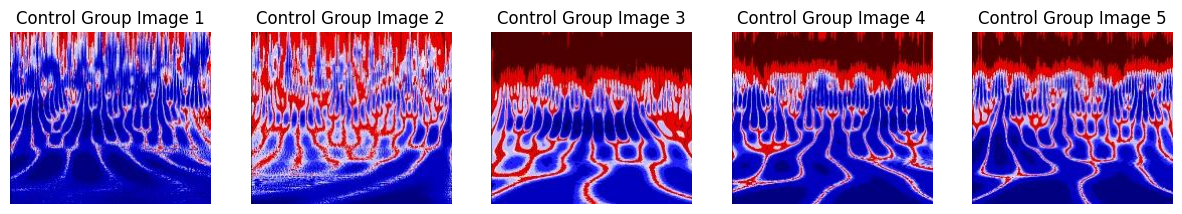

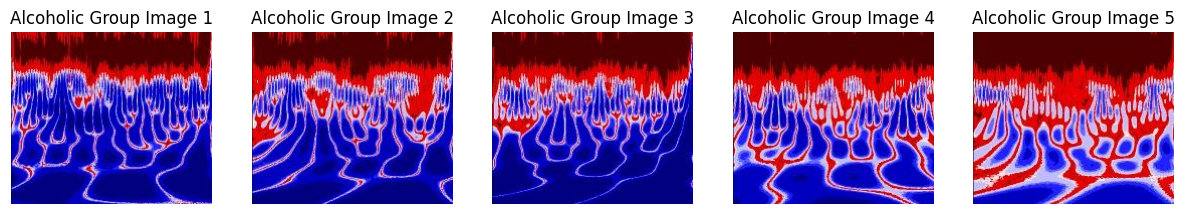

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display a few images from each group
def display_images(image_list, group_name, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_list[:num_images]):
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'{group_name} Image {i+1}')
        plt.axis('off')
    plt.show()

# Display some Control group images
display_images(List_EEG_Con, 'Control Group')

# Display some Alcoholic group images
display_images(List_EEG_Alc, 'Alcoholic Group')


In [ ]:
from fastcore.foundation import GetAttr, add_props # Import both GetAttr and add_props

class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i]) # Now add_props is available

In [ ]:
from fastai.vision.all import * # Import necessary modules from fastai

EEGs = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=99),
    get_y=parent_label,
    item_tfms=Resize(200,172)
)

In [ ]:
dls = EEGs.dataloaders(root_dir)
dls

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [ ]:
learn.save('eegResnet18.mdl')

Path('models/eegResnet18.mdl.pth')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

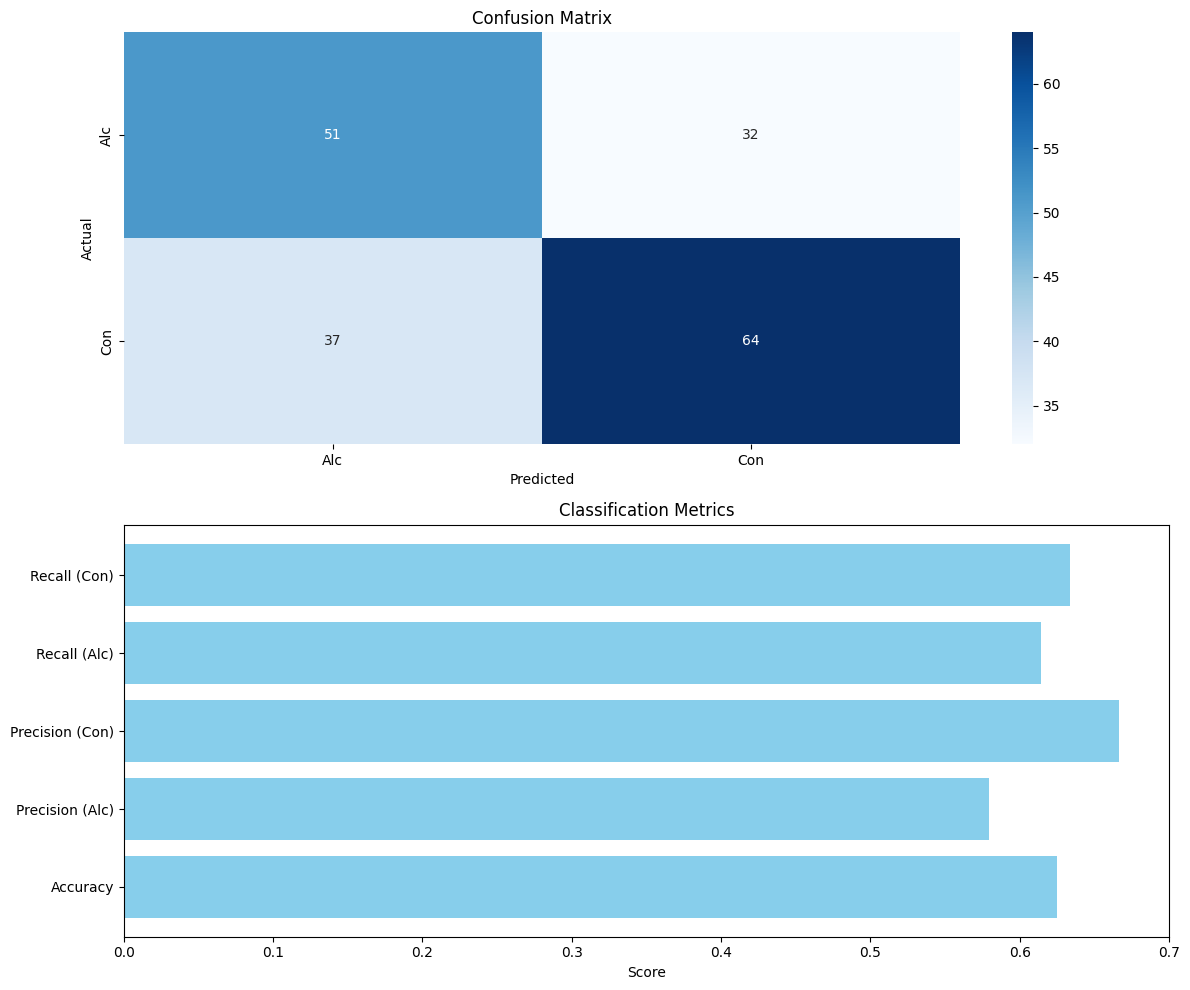

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fastai.vision.all import *

# Get the interpretation object and confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.confusion_matrix()

# Calculate accuracy, precision, and recall
def calculate_metrics(cm):
    accuracy = np.diag(cm).sum() / cm.sum()
    precision = np.diag(cm) / cm.sum(axis=0)
    recall = np.diag(cm) / cm.sum(axis=1)
    return accuracy, precision, recall

accuracy, precision, recall = calculate_metrics(cm)

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))

# Plot confusion matrix
plt.subplot(2, 1, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=interp.vocab, yticklabels=interp.vocab)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Plot metrics
plt.subplot(2, 1, 2)
metrics = ['Accuracy'] + [f'Precision ({label})' for label in interp.vocab] + [f'Recall ({label})' for label in interp.vocab]
values = [accuracy] + list(precision) + list(recall)
plt.barh(metrics, values, color='skyblue')
plt.xlabel('Score')
plt.title('Classification Metrics')

plt.tight_layout()
plt.show()


In [ ]:
accuracy

0.625

In [ ]:
 precision

array([0.57954545, 0.66666667])

In [ ]:
recall

array([0.61445783, 0.63366337])

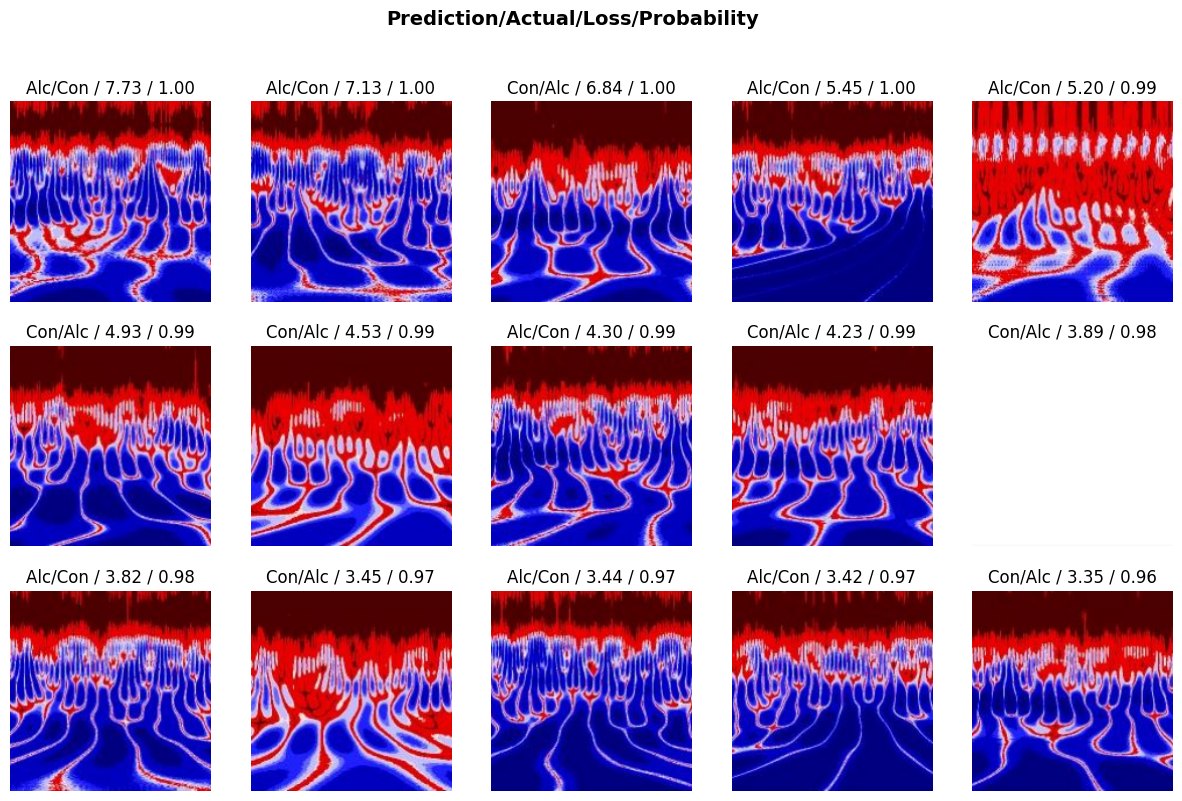

In [ ]:
interp.plot_top_losses(15)

In [ ]:
 interp.top_losses(15)

(TensorBase([7.7276, 7.1331, 6.8365, 5.4537, 5.2029, 4.9257, 4.5291, 4.3045,
             4.2346, 3.8881, 3.8201, 3.4453, 3.4411, 3.4248, 3.3475]),
 TensorBase([182,  10,  37,  88, 123,  63,  48, 158, 164, 171,  56, 108,  20,
             122, 104]))

In [ ]:
del learn